<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/version2/modeling/where_modeling/CA_OR_Similarity_PCA_SupetSetData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

This colab is for KNN similarity 
* to find the counties from Oregon, that are similar to CA widespread counties


# Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')

In [ ]:
#drive.flush_and_unmount(600000)

In [ ]:
!ls '/content/drive/Shareddrives/CMPE 295- Master Project/projectdata-2021'

# Import package

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler as ss
import itertools
from scipy import linalg
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import numpy as np
import matplotlib.pyplot as plt

# Running for all states in Pacific regions

In [ ]:
base_state = "California"
other_states = ["Arizona","New Mexico","Colorado","Alaska","Idaho","Montana","Nevada","Hawaii","Utah","Washington","Wyoming","Oregon"]

In [ ]:
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/Bayesian-Metrics/'
filename = 'All_Superset_bins_dataset_Apr05.csv'


In [ ]:
all_binning_data = pd.read_csv(location+filename, low_memory=False)
all_binning_data.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,CTNAME
0,2020-02-29,Alabama,1001.0,0.0,Autauga County,0.0,13.230357,90.214286,11.071429,15.071429,0.000,0.0,3.928571,-0.50,35.853419,Alabama,16.285714,15.357143,3.313571,41.6500,0.785714,38.264286,0.672857,2.637857,0.000,55601.0,2.250,0.11,19.0,58786.0,19.0,2.8,48.68,19.0,101.0,3.79,0.33,0.025,0.00000,0.00000,43.5000,47.100000,2.121429,0.000714,0.000000,0.00,0.0000,0.000714,36.5000,0.35000,3.50000,3.200,0.3,0.00000,0.000000,0.000000,Autauga County
1,2020-03-15,Alabama,1001.0,0.5,Autauga County,0.0,6.888813,46.875000,-20.312500,11.500000,-0.875,0.0,-27.000000,7.75,35.853419,Alabama,35.062500,22.625000,2.909375,38.1875,0.787500,28.881250,0.490000,2.419375,0.375,55601.0,-6.225,0.11,19.0,58786.0,19.0,2.8,48.68,19.0,101.0,3.79,0.33,0.025,0.00675,0.06375,30.9375,47.348657,33.150000,0.440625,0.671875,10.75,2.3125,0.041250,51.1875,10.70625,5.69375,19.225,0.3,0.61875,0.899264,0.610215,Autauga County


In [ ]:
all_binning_data['Province_State'].unique()

array(['Alabama', 'Georgia', 'West Virginia', 'Tennessee', 'Iowa',
       'Kansas', 'Kentucky', 'Missouri', 'Nebraska', 'Ohio',
       'Pennsylvania', 'Florida', 'Michigan', 'Mississippi',
       'South Carolina', 'North Carolina', 'Oklahoma', 'Virginia',
       'Arkansas', 'Illinois', 'Indiana', 'Minnesota', 'South Dakota',
       'Idaho', 'Maine', 'Massachusetts', 'Vermont', 'Washington',
       'Oregon', 'Colorado', 'Montana', 'Maryland', 'Rhode Island',
       'Utah', 'Alaska', 'Arizona', 'New Hampshire', 'Nevada',
       'New Mexico', 'Wyoming', 'New Jersey', 'Connecticut', 'Delaware',
       'Hawaii', 'North Dakota', 'Louisiana'], dtype=object)

In [ ]:
important_cols = ['Tests.done.1000.people',
 'X..staying.home',
 'Unemployment.rate',
 'X..people.older.than.60',
 'X..working.from.home',
 'X.days..decreasing.ILI.cases',
 'X..Male',
 'positivity_rate',
 'X..out.of.county.trips',
 'parks_percent_change_from_baseline',#mobility
 'Work.trips.person',
 'm50_index',#Social distancing
 'Imported.COVID.cases',
 'X..out.of.state.trips',
 'Miles.person',
 'X.days..decreasing.COVID.cases',
 'grocery_and_pharmacy_percent_change_from_baseline',#mobility
 'New Cases/100k population',
 'transit_stations_percent_change_from_baseline',#mobility
 'Testing.capacity',
 'retail_and_recreation_percent_change_from_baseline',#mobility
 'Unemployment.claims.1000.people']

## Util methods

In [ ]:
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from tqdm import tqdm

def key_consine_similarity(tupple):
    return tupple[1]

# This method computes the distance between each vectors with predicted_vectors input
# in our case, vectors is CA data , predicted_vectors is OR data

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(vectors) # size of your CA data
  
    cosine_similarities = []
    simiarity_ids = []
    cosine_distances = []

    for i in range(len(predicted_vectors)): #OR
      max_cosine = 0
      max_j = -1
      for j in range(data_size): #CA
      
        cosine_sim_val = cosine_similarity(vectors[j].reshape(1,-1), predicted_vectors[i].reshape(1,-1)) 
        if max_cosine < cosine_sim_val:
            max_cosine = cosine_sim_val
            max_j = j
      cosine_similarities.append((max_j, max_cosine))
      simiarity_ids.append(max_j)
      cosine_distances.append(max_cosine)

    return simiarity_ids,cosine_distances,cosine_similarities


In [ ]:
base_state_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/CA_SuperData_Labeled_Guideline_Feb26.csv',low_memory=False)
#base_state_data['positivity_rate'] = (base_state_data['New.cases.1000.people'] / base_state_data['Tests.done.1000.people'])* 100/1000
base_state_data.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,positivity_rate,rolling_avg_new_cases/100k,daily_growth_range,growth_label
0,2020-03-01,California,6001,0,Alameda County,0.0,3.684,58,6.0,9.0,15.0,1.0,4.0,0.0,860.757075,California,CA,6001,Alameda County,6,37,26,2.93,25.4,0.4,36.8,0.25,2.68,0,1666753,-5.1,15.04,19,92574,10.5,22.5,49.11,1155,131,2.05,0.22,0.0,0.0,0.0,37,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,minimal
1,2020-03-02,California,6001,0,Alameda County,0.0,6.182,98,4.0,7.0,7.0,-1.0,3.0,0.0,860.757075,California,CA,6001,Alameda County,6,17,20,3.38,28.2,0.4,38.1,0.63,2.74,0,1666753,-2.9,15.04,19,92574,10.5,22.5,49.11,1155,131,2.05,0.22,0.0,0.0,0.0,38,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,minimal


In [ ]:
base_state_data_filtered  = base_state_data[important_cols]
all_state_df = pd.DataFrame(columns = ['Date', 'Province_State', 'FIPS', 'New cases', 'County Name',
       'mask_rule_severity', 'm50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'PopDensity', 'State_Name',
       'Social.distancing.index', 'X..staying.home', 'Trips.person',
       'X..out.of.county.trips', 'X..out.of.state.trips', 'Miles.person',
       'Work.trips.person', 'Non.work.trips.person', 'New.COVID.cases',
       'Population', 'X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Employment.density',
       'X..hot.spots.1000.people', 'Hospital.beds.1000.people',
       'ICUs.1000.people', 'X..contact.tracing.workers.1000.people',
       'New.cases.1000.people', 'Active.cases.1000.people',
       'X.days..decreasing.COVID.cases', 'X..hospital.bed.utilization',
       'Testing.capacity', 'Tests.done.1000.people', 'X..ICU.utilization',
       'Ventilator.shortage', 'Imported.COVID.cases',
       'COVID.exposure.1000.people', 'X.days..decreasing.ILI.cases',
       'Unemployment.claims.1000.people', 'Unemployment.rate',
       'X..working.from.home', 'Cumulative.inflation.rate', 'COVID.death.rate',
       'New Cases/100k population', 'rolling_avg_new_cases/100k', 'CTNAME',
       'positivity_rate', 'similiary_score', 'cosine_distance',
       'similar_county'])


In [ ]:
state_data.head()

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,CTNAME
929,2020-02-29,Hawaii,15001.0,0.000000,Hawaii County,0.0,6.197571,95.357143,-0.785714,0.857143,-2.785714,-1.714286,-0.571429,1.071429,18.944303,Hawaii,17.642857,17.500000,3.275000,1.828571,0.578571,41.442857,0.348571,2.927857,0.071429,200983.0,0.507143,1.24,28.0,59297.0,0.6,12.7,49.72,15.0,136.0,2.34,0.15,0.021,0.000364,0.000000,26.357143,56.700000,57.142857,0.000000,0.000000,0.000000,0.000000,0.015714,5.500000,1.000000,2.600000,5.500000,0.600000,0.000000,0.000000,0.005077,Hawaii County
930,2020-03-15,Hawaii,15001.0,0.750000,Hawaii County,0.0,3.028313,46.312500,-36.375000,-18.937500,-49.187500,-46.437500,-30.625000,12.187500,18.944303,Hawaii,45.500000,25.687500,2.698750,1.143750,0.375000,28.825000,0.275625,2.423125,0.812500,200983.0,-16.825000,1.24,28.0,59297.0,0.6,12.7,49.72,15.0,136.0,2.34,0.15,0.021,0.003638,0.045625,1.312500,56.739898,25.068750,1.776250,0.171250,0.375000,0.000000,0.033750,16.187500,22.481250,8.593750,20.443750,0.600000,0.118125,0.373166,0.195468,Hawaii County
931,2020-03-31,Hawaii,15001.0,1.933333,Hawaii County,0.0,1.368400,20.666667,-54.200000,-31.533333,-74.066667,-81.466667,-44.933333,16.933333,18.944303,Hawaii,59.000000,28.733333,2.528667,0.600000,0.140000,23.340000,0.236000,2.294667,1.933333,200983.0,-21.220000,1.24,28.0,59297.0,0.6,12.7,49.72,15.0,136.0,2.34,0.15,0.021,0.009740,0.262667,1.000000,57.115235,2.640000,9.934667,2.100000,4.266667,0.066667,0.058000,32.200000,27.573333,21.166667,21.780000,0.226667,5.494667,0.961939,0.876644,Hawaii County
932,2020-04-15,Hawaii,15001.0,1.928571,Hawaii County,0.0,1.651643,25.071429,-55.357143,-32.857143,-71.571429,-81.285714,-42.357143,15.500000,18.944303,Hawaii,56.142857,26.642857,2.635000,0.557143,0.128571,23.907143,0.238571,2.395714,1.928571,200983.0,-17.764286,1.24,28.0,59297.0,0.6,12.7,49.72,15.0,136.0,2.34,0.15,0.021,0.007943,0.350714,1.071429,57.114550,2.307143,17.878571,2.060714,4.071429,0.571429,0.076429,47.500000,15.357143,24.128571,19.614286,0.200000,11.104286,0.959569,1.228655,Hawaii County
933,2020-04-30,Hawaii,15001.0,0.333333,Hawaii County,0.0,1.560400,23.600000,-50.200000,-25.066667,-67.600000,-79.066667,-38.333333,14.133333,18.944303,Hawaii,52.200000,24.200000,2.749333,0.546667,0.080000,25.913333,0.227333,2.519333,0.400000,200983.0,-13.500000,1.24,28.0,59297.0,0.6,12.7,49.72,15.0,136.0,2.34,0.15,0.021,0.002007,0.162667,5.800000,56.735030,1.786667,24.794667,0.320667,0.466667,0.066667,0.093333,62.066667,8.920000,22.526667,20.566667,0.200000,12.690667,0.165852,0.180067,Hawaii County


In [ ]:
new_cases_idx = state_data.columns.get_loc('New.cases.1000.people')
testing_idx = state_data.columns.get_loc('Tests.done.1000.people')
print(new_cases_idx, testing_idx)

38 43


In [ ]:
for state in other_states:
  state_data = all_binning_data[all_binning_data['Province_State'] == state]
  row, cols = state_data.shape
  if row >0:
    state_data['positivity_rate'] = (state_data['New.cases.1000.people'] / state_data['Tests.done.1000.people'])* 100/1000
    state_data = state_data.replace([np.inf, -np.inf], np.nan)
    state_data_filtered = state_data[important_cols]
    state_data_filtered = state_data_filtered.fillna(0)
    simiarity_ids,cosine_distances,cosine_similarities = get_computed_similarities(vectors=base_state_data_filtered.values, predicted_vectors=state_data_filtered.values)
    state_data['similiary_score'] = cosine_similarities
    cosine_distance_array = []
    for cosine_distance in cosine_distances:
      cosine_distance_array.append(cosine_distance[0][0])
    state_data['cosine_distance'] = cosine_distance_array
    similar_county_names = []
    for id in simiarity_ids:
      similar_county_name = base_state_data.iloc[id]['County Name']
      similar_county_names.append(similar_county_name)

    print('length: ',len(similar_county_names))
    state_data['similar_county']= similar_county_names
    print(state_data.head(2))
    all_state_df = all_state_df.append(state_data)

    #break







length:  20
           Date Province_State  ...  cosine_distance    similar_county
929  2020-02-29         Hawaii  ...         0.928586   Monterey County
930  2020-03-15         Hawaii  ...         0.982034  Mendocino County

[2 rows x 61 columns]
length:  20
           Date Province_State  ...  cosine_distance   similar_county
710  2020-02-29           Utah  ...         0.976517    Merced County
711  2020-03-15           Utah  ...         0.968237  Humboldt County

[2 rows x 61 columns]
length:  20
           Date Province_State  ...  cosine_distance  similar_county
571  2020-02-29     Washington  ...         0.991650   Colusa County
572  2020-03-15     Washington  ...         0.963443   Tehama County

[2 rows x 61 columns]
length:  19
           Date Province_State  ...  cosine_distance         similar_county
850  2020-02-29        Wyoming  ...         0.992350  San Bernardino County
851  2020-03-15        Wyoming  ...         0.987375            Inyo County

[2 rows x 61 columns]
le

In [ ]:
all_state_df['similar_county'].unique()

array(['San Joaquin County', 'Madera County', 'Sutter County',
       'Tehama County', 'Napa County', 'Merced County', 'Marin County',
       'San Luis Obispo County', 'Inyo County', 'Mariposa County',
       'Calaveras County', 'San Benito County', 'Imperial County',
       'Plumas County', 'Lake County', 'Del Norte County',
       'Lassen County', 'Amador County', 'Mono County', 'Yolo County',
       'Alameda County', 'Orange County', 'San Bernardino County',
       'Sacramento County', 'Sonoma County', 'Ventura County',
       'Los Angeles County', 'Mendocino County', 'Glenn County',
       'Siskiyou County', 'Shasta County', 'Colusa County',
       'San Diego County', 'Fresno County', 'Solano County',
       'Santa Cruz County', 'El Dorado County', 'Tulare County',
       'Stanislaus County', 'Monterey County', 'Humboldt County',
       'Tuolumne County', 'Butte County', 'Nevada County', 'Yuba County',
       'Kern County', 'Kings County'], dtype=object)

In [ ]:
all_state_df['Province_State'].unique()

array(['Arizona', 'New Mexico', 'Colorado', 'Alaska', 'Idaho', 'Montana',
       'Nevada', 'Hawaii', 'Utah', 'Washington', 'Wyoming', 'Oregon'],
      dtype=object)

## Export ot CSV all states in Pacific location

In [ ]:

from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/cosine_distance_files/'
filename = 'CA_AllStates_PCA_SimilarityScore_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
all_state_df.to_csv(location+filename,index=False)

CA_AllStates_PCA_SimilarityScore_Apr05.csv


# Below code cells is for Oregon only [ not used ]

# Load Oregon Binning Superset Data

In [ ]:
or_bin_superset_data = pd.read_csv('/content/drive/Shareddrives/CMPE 295- Master Project/projectdata-2021/OR_Superset_bins_dataset_Mar26.csv',low_memory=False)



In [ ]:
print(or_bin_superset_data.shape)


(580, 58)


In [ ]:
or_bin_superset_data.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,State,CTNAME
0,2020-02-29,Oregon,41029.0,0.142857,Jackson County,0.0,4.668500,90.071429,6.857143,7.714286,43.214286,-13.357143,0.857143,-0.357143,29.723811,Oregon,20.357143,20.428571,3.827143,10.035714,2.635714,36.807143,0.591429,3.236429,0.142857,219564.0,0.642857,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.000643,0.002143,17.000,48.812683,5.992857,0.035714,0.025714,0.214286,0.0000,0.061429,0.0000,1.00000,3.30000,7.25000,0.6,0.000,0.065064,9.063012,OR,Jackson County
1,2020-03-15,Oregon,41029.0,1.125000,Jackson County,0.0,2.250875,43.125000,-31.625000,-4.500000,29.687500,-30.750000,-29.187500,9.375000,29.723811,Oregon,41.562500,29.000000,3.193750,9.775000,2.700000,27.906250,0.477500,2.715625,1.125000,219564.0,-15.550000,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.003894,0.055000,3.375,49.306294,5.418750,1.125000,1.244375,9.562500,1.9375,0.046250,3.0625,8.46875,6.64375,23.13125,0.6,3.675,0.512379,0.203325,OR,Jackson County


In [ ]:
print(or_bin_superset_data['County Name'].nunique())
or_bin_superset_data['County Name'].unique()

29


array(['Jackson County', 'Jefferson County', 'Marion County',
       'Washington County', 'Benton County', 'Columbia County',
       'Lincoln County', 'Polk County', 'Union County', 'Douglas County',
       'Baker County', 'Linn County', 'Coos County', 'Curry County',
       'Morrow County', 'Clackamas County', 'Clatsop County',
       'Crook County', 'Deschutes County', 'Hood River County',
       'Josephine County', 'Klamath County', 'Lane County',
       'Malheur County', 'Multnomah County', 'Tillamook County',
       'Umatilla County', 'Wasco County', 'Yamhill County'], dtype=object)

In [ ]:
or_bin_superset_data['positivity_rate'] = (or_bin_superset_data['New.cases.1000.people'] / or_bin_superset_data['Tests.done.1000.people'])* 100/1000
or_bin_superset_data.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,State,CTNAME,positivity_rate
0,2020-02-29,Oregon,41029.0,0.142857,Jackson County,0.0,4.668500,90.071429,6.857143,7.714286,43.214286,-13.357143,0.857143,-0.357143,29.723811,Oregon,20.357143,20.428571,3.827143,10.035714,2.635714,36.807143,0.591429,3.236429,0.142857,219564.0,0.642857,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.000643,0.002143,17.000,48.812683,5.992857,0.035714,0.025714,0.214286,0.0000,0.061429,0.0000,1.00000,3.30000,7.25000,0.6,0.000,0.065064,9.063012,OR,Jackson County,0.001800
1,2020-03-15,Oregon,41029.0,1.125000,Jackson County,0.0,2.250875,43.125000,-31.625000,-4.500000,29.687500,-30.750000,-29.187500,9.375000,29.723811,Oregon,41.562500,29.000000,3.193750,9.775000,2.700000,27.906250,0.477500,2.715625,1.125000,219564.0,-15.550000,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.003894,0.055000,3.375,49.306294,5.418750,1.125000,1.244375,9.562500,1.9375,0.046250,3.0625,8.46875,6.64375,23.13125,0.6,3.675,0.512379,0.203325,OR,Jackson County,0.000346


#  Load CA Superset Labeled Data

In [ ]:
ca_labeled_superset_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/CA_SuperData_Labeled_Guideline_Feb26.csv',low_memory=False)
ca_labeled_superset_data.head()

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,positivity_rate,rolling_avg_new_cases/100k,daily_growth_range,growth_label
0,2020-03-01,California,6001,0,Alameda County,0.0,3.684,58,6.0,9.0,15.0,1.0,4.0,0.0,860.757075,California,CA,6001,Alameda County,6,37,26,2.93,25.4,0.4,36.8,0.25,2.68,0,1666753,-5.1,15.04,19,92574,10.5,22.5,49.11,1155,131,2.05,0.22,0.0,0.0000,0.0,37,54.0,0.0,0.00,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.00,0.000000,0.000,0.0,0.0,minimal
1,2020-03-02,California,6001,0,Alameda County,0.0,6.182,98,4.0,7.0,7.0,-1.0,3.0,0.0,860.757075,California,CA,6001,Alameda County,6,17,20,3.38,28.2,0.4,38.1,0.63,2.74,0,1666753,-2.9,15.04,19,92574,10.5,22.5,49.11,1155,131,2.05,0.22,0.0,0.0000,0.0,38,54.0,0.0,0.00,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.00,0.000000,0.000,0.0,0.0,minimal
2,2020-03-03,California,6001,1,Alameda County,0.0,6.271,100,5.0,12.0,41.0,0.0,1.0,-1.0,860.757075,California,CA,6001,Alameda County,6,16,18,3.61,27.1,0.3,32.7,0.67,2.94,1,1666753,4.1,15.04,19,92574,10.5,22.5,49.11,1155,131,2.05,0.22,0.0,0.0002,0.0,0,54.0,0.0,0.00,0.0,0,1,0.05,42,1.1,5.3,5.7,0.6,0.00,0.059997,0.000,0.0,0.0,minimal
3,2020-03-04,California,6001,0,Alameda County,0.0,6.209,99,1.0,6.0,23.0,-3.0,1.0,0.0,860.757075,California,CA,6001,Alameda County,6,14,18,3.55,27.9,0.3,36.9,0.68,2.87,0,1666753,1.7,15.04,19,92574,10.5,22.5,49.11,1155,131,2.05,0.22,0.0,0.0002,0.0,0,54.0,10.3,0.01,0.0,0,1,0.06,42,1.1,5.3,5.7,0.6,0.04,0.000000,0.002,0.0,0.0,minimal
4,2020-03-05,California,6001,0,Alameda County,0.0,6.654,106,1.0,6.0,12.0,-5.0,-1.0,1.0,860.757075,California,CA,6001,Alameda County,6,15,19,3.54,28.1,0.3,36.8,0.66,2.88,0,1666753,2.0,15.04,19,92574,10.5,22.5,49.11,1155,131,2.05,0.22,0.0,0.0002,0.0,0,54.0,10.3,0.01,0.0,0,1,0.06,42,1.1,5.3,5.7,0.6,0.04,0.000000,0.002,0.0,0.0,minimal


In [ ]:
ca_labeled_superset_data['State'].unique()

array(['CA'], dtype=object)

In [ ]:
ca_labeled_superset_data.shape

(15391, 63)

In [ ]:
ca_labeled_superset_data.growth_label.unique()

array(['minimal', 'nochange', 'widespread'], dtype=object)

In [ ]:
#ca_labeled_superset_data = ca_labeled_superset_data[ca_labeled_superset_data['growth_label']=='widespread']

In [ ]:
ca_labeled_superset_data.shape

(15391, 63)

In [ ]:
print("CA labeled:", ca_labeled_superset_data.Date.min(),ca_labeled_superset_data.Date.max())
print("Oregon Bining:", or_bin_superset_data.Date.min(),or_bin_superset_data.Date.max())

CA labeled: 2020-03-01 2020-12-28
Oregon Bining: 2020-02-29 2020-12-15


# Filtering widespread data from CA

In [ ]:
ca_widespread_data = ca_labeled_superset_data[ca_labeled_superset_data['growth_label']=='widespread']
print(ca_widespread_data.shape)
ca_widespread_data.head(2)

(3780, 63)


,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,positivity_rate,rolling_avg_new_cases/100k,daily_growth_range,growth_label
22,2020-03-23,California,6001,47,Alameda County,0.0,0.090,1,-49.0,-23.0,-23.0,-71.0,-63.0,28.0,860.757075,California,CA,6001,Alameda County,6,65,42,2.33,22.6,0.2,20.0,0.37,1.96,47,1666753,-30.6,15.04,19,92574,10.5,22.5,49.11,1155,131,2.05,0.22,0.0,0.0140,0.05,0,54.475115,12.1,0.36,1.09,91,27,0.04,0,22.2,9.7,32.5,0.6,2.22,2.819854,0.003889,0.857098,0.342839,widespread
28,2020-03-29,California,6001,50,Alameda County,0.0,0.028,0,-58.0,-27.0,-14.0,-64.0,-44.0,17.0,860.757075,California,CA,6001,Alameda County,6,79,50,1.97,16.2,0.1,13.9,0.19,1.77,50,1666753,-37.3,15.04,19,92574,10.5,22.5,49.11,1155,131,2.05,0.22,0.0,0.0184,0.15,0,54.997320,21.7,0.66,4.70,192,43,0.06,7,23.4,13.4,31.7,0.6,5.55,2.999845,0.002788,1.705626,0.402836,widespread


# Using PCA Columns

## Column Mapping

In [ ]:
ca_labeled_superset_data.columns

Index(['Date', 'Province_State', 'FIPS', 'New cases', 'County Name',
       'mask_rule_severity', 'm50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'PopDensity', 'State_Name',
       'State', 'CTFIPS', 'CTNAME', 'STFIPS', 'Social.distancing.index',
       'X..staying.home', 'Trips.person', 'X..out.of.county.trips',
       'X..out.of.state.trips', 'Miles.person', 'Work.trips.person',
       'Non.work.trips.person', 'New.COVID.cases', 'Population',
       'X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Employment.density',
       'X..hot.spots.1000.people', 'Hospital.beds.1000.peop

'Province_State', 'FIPS', 'County Name','PopDensity', 'State_Name','State', 'CTFIPS', 'CTNAME', 'STFIPS',
'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Employment.density','Testing.capacity', 'Ventilator.shortage','Unemployment.rate','Unemployment.claims.1000.people',

In [ ]:
or_bin_superset_data.columns

Index(['Date', 'Province_State', 'FIPS', 'New cases', 'County Name',
       'mask_rule_severity', 'm50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'PopDensity', 'State_Name',
       'Social.distancing.index', 'X..staying.home', 'Trips.person',
       'X..out.of.county.trips', 'X..out.of.state.trips', 'Miles.person',
       'Work.trips.person', 'Non.work.trips.person', 'New.COVID.cases',
       'Population', 'X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Employment.density',
       'X..hot.spots.1000.people', 'Hospital.beds.1000.people',
       'ICUs.1000.people', 'X..contact.tr

In [ ]:
required_cols = [ 'mask_rule_severity', 'm50_index', #'FIPS',
        'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'PopDensity',
        'Social.distancing.index','X..staying.home', 'Trips.person', 'X..out.of.county.trips',
       'X..out.of.state.trips', 'Miles.person', 'Work.trips.person',
       'Non.work.trips.person',#'Population',
       'X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male','Employment.density',
       'X..hot.spots.1000.people', 'Hospital.beds.1000.people',
       'ICUs.1000.people','X.days..decreasing.COVID.cases', 'X..hospital.bed.utilization',
       'Testing.capacity', 'Tests.done.1000.people', 'X..ICU.utilization',
       'Ventilator.shortage', 'Imported.COVID.cases',
       'COVID.exposure.1000.people', 'X.days..decreasing.ILI.cases',
       'Unemployment.claims.1000.people', 'Unemployment.rate',
       'X..working.from.home', 'Cumulative.inflation.rate', 'COVID.death.rate',
       'rolling_avg_new_cases/100k']

### Important columns from PCA

In [ ]:
important_cols = ['Tests.done.1000.people',
 'X..staying.home',
 'Unemployment.rate',
 'X..people.older.than.60',
 'X..working.from.home',
 'X.days..decreasing.ILI.cases',
 'X..Male',
 'positivity_rate',
 'X..out.of.county.trips',
 'parks_percent_change_from_baseline',#mobility
 'Work.trips.person',
 'm50_index',#Social distancing
 'Imported.COVID.cases',
 'X..out.of.state.trips',
 'Miles.person',
 'X.days..decreasing.COVID.cases',
 'grocery_and_pharmacy_percent_change_from_baseline',#mobility
 'New Cases/100k population',
 'transit_stations_percent_change_from_baseline',#mobility
 'Testing.capacity',
 'retail_and_recreation_percent_change_from_baseline',#mobility
 'Unemployment.claims.1000.people']

**Summary**: The latent features (loc2vec features ) describe the probalistic causal behaviour of the pandemic. The features are responsible for describing the sudden increase or surge of the pandemic. The counties with closest 

* Surge in LA -> Surge in WA county in OR


In [ ]:
ca_labeled_superset_data_filtered = ca_labeled_superset_data[required_cols]


In [ ]:
or_bin_superset_data_filtered = or_bin_superset_data[required_cols]

#### Updated to select PCA important columns 

In [ ]:

ca_labeled_superset_data_filtered = ca_labeled_superset_data[important_cols]
or_bin_superset_data_filtered = or_bin_superset_data[important_cols]

In [ ]:
print(ca_labeled_superset_data_filtered.shape)
print(or_bin_superset_data_filtered.shape)

(15391, 22)
(580, 22)


## KNN Similarity between CA data and OR binning reduced data



In [ ]:
#https://towardsdatascience.com/cosine-similarity-how-does-it-measure-the-similarity-maths-behind-and-usage-in-python-50ad30aad7db
#### Reference Code 
# using sklearn to calculate cosine similarity
#from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
#cos_sim=cosine_similarity(A.reshape(1,-1),B.reshape(1,-1))
#print (f"Cosine Similarity between A and B:{cos_sim}")- high is good
#print (f"Cosine Distance between A and B:{1-cos_sim}")- distance less is good

In [ ]:
or_bin_superset_data_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
Tests.done.1000.people,638.0,134.736406,152.547427,0.035436,18.920245,85.068333,188.204375,602.726667
X..staying.home,638.0,26.267425,4.020645,16.375000,23.317708,25.861905,28.796429,40.400000
Unemployment.rate,638.0,9.103396,2.980959,3.300000,6.735425,7.900000,11.509416,14.619313
X..people.older.than.60,638.0,27.757053,6.047606,18.000000,22.250000,27.000000,33.000000,43.000000
X..working.from.home,638.0,31.298635,6.644006,7.247692,29.956818,32.658571,33.776515,38.450000
X.days..decreasing.ILI.cases,638.0,65.940807,58.171010,0.000000,18.915909,35.000000,109.280769,175.000000
X..Male,638.0,50.183386,1.527385,48.140000,49.247500,49.700000,50.480000,54.490000
positivity_rate,638.0,0.000147,0.000526,0.000000,0.000018,0.000043,0.000108,0.009940
X..out.of.county.trips,638.0,28.344217,12.040692,7.113333,18.676667,28.025833,36.771667,75.200000
parks_percent_change_from_baseline,638.0,24.009202,35.354196,-24.733333,0.000000,11.273810,33.196875,176.866667


In [ ]:
ca_labeled_superset_data_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
Tests.done.1000.people,15391.0,233.967335,221.686124,0.000000,26.940000,178.160000,401.410000,812.210000
X..staying.home,15391.0,26.896498,5.921109,13.000000,23.000000,26.000000,30.000000,61.000000
Unemployment.rate,15391.0,11.928374,3.167767,5.300000,9.700000,11.400000,14.900000,17.000000
X..people.older.than.60,15391.0,22.703008,6.106907,14.000000,18.000000,21.000000,26.000000,38.000000
X..working.from.home,15391.0,35.345260,7.158810,5.700000,34.400000,36.900000,38.100000,42.300000
X.days..decreasing.ILI.cases,15391.0,120.561822,81.906428,0.000000,42.000000,119.000000,196.000000,266.000000
X..Male,15391.0,50.421286,2.449918,48.180000,49.470000,49.840000,50.730000,66.290000
positivity_rate,15391.0,0.000299,0.001561,0.000000,0.000015,0.000042,0.000109,0.048667
X..out.of.county.trips,15391.0,23.440465,10.294389,2.100000,15.100000,22.400000,30.900000,100.000000
parks_percent_change_from_baseline,15391.0,5.290689,37.515584,-83.000000,-13.000000,0.000000,16.000000,323.000000


In [ ]:
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from tqdm import tqdm

def key_consine_similarity(tupple):
    return tupple[1]

# This method computes the distance between each vectors with predicted_vectors input
# in our case, vectors is CA data , predicted_vectors is OR data

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(vectors) # size of your CA data
    #print("len of OR:", len(predicted_vectors)) #size of OR
    #print("len of CA:", data_size)
    cosine_similarities = []
    simiarity_ids = []
    cosine_distances = []

    for i in range(len(predicted_vectors)): #OR
      max_cosine = 0
      max_j = -1
      #print('actual : ',predicted_vectors[i],' reshaped : ',predicted_vectors[i].reshape(1,-1))
      for j in range(data_size): #CA
        ##cosine_sim_val = (1 - cosine(vectors[j], predicted_vectors[i]))
        # if i == 31:
        #   print(vectors[j].reshape(1,-1))
        #   print(predicted_vectors[i].reshape(1,-1))
        cosine_sim_val = cosine_similarity(vectors[j].reshape(1,-1), predicted_vectors[i].reshape(1,-1)) 
        if max_cosine < cosine_sim_val:
            max_cosine = cosine_sim_val
            max_j = j
      cosine_similarities.append((max_j, max_cosine))
      simiarity_ids.append(max_j)
      cosine_distances.append(max_cosine)
        #if cosine_sim_val > 0.5: # update threshold
          #continue
      #if i > 50: break
        
    #print('len cosine_similarities : ',len(cosine_similarities))
    #return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)
    return simiarity_ids,cosine_distances,cosine_similarities

def display_top_n(sorted_cosine_similarities, n=10):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        print('News Title: ', merged_data.iloc[index, 0])  
        print('News statement: ', merged_data.iloc[index, 1])  
        print('News label: ', merged_data.iloc[index, 4])  

        print('Cosine Sim Val :', consine_sim_val)
        print('---------------------------------')

In [ ]:
or_bin_superset_data_filtered.values[31].reshape(1,-1)

array([[1.16170000e+02, 2.30000000e+01, 7.85000000e+00, 2.60000000e+01,
        3.81500000e+01, 1.47000000e+02, 5.18900000e+01, 2.84669020e-04,
        4.43500000e+01, 0.00000000e+00, 2.60000000e-01, 6.75000000e+01,
        7.10000000e+01, 3.40000000e+00, 4.99500000e+01, 0.00000000e+00,
        0.00000000e+00, 3.10019841e+01, 0.00000000e+00, 4.75000000e+00,
        3.05000000e+01, 1.30000000e+00]])

In [ ]:
or_bin_superset_data[or_bin_superset_data.index == 31]

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,State,CTNAME,positivity_rate
31,2020-08-15,Oregon,41031.0,7.5,Jefferson County,0.0,3.9315,67.5,30.5,0.0,0.0,0.0,-16.0,0.0,5.013675,Oregon,24.5,23.0,3.88,44.35,3.4,49.95,0.26,3.62,7.5,24192.0,24.25,1.08,26.0,50339.0,0.9,20.0,51.89,4.0,102.0,2.2,0.2,0.024,0.3307,2.235,0.0,52.880299,4.75,116.17,6.8,78.5,71.0,3.0,147.0,1.3,7.85,38.15,1.51,3.08,31.001984,30.706727,OR,Jefferson County,0.000285


In [ ]:
%%time
simiarity_ids,cosine_distances,cosine_similarities = get_computed_similarities(vectors=ca_labeled_superset_data_filtered.values, predicted_vectors=or_bin_superset_data_filtered.values)

CPU times: user 24min 50s, sys: 32.2 s, total: 25min 22s
Wall time: 24min 31s


In [ ]:
print(cosine_similarities[:10][0][1])
float(cosine_similarities[:10][0][1])

[[0.98834811]]


0.9883481068672355

In [ ]:
or_bin_superset_data['FIPS'].unique()

array([41029., 41031., 41047., 41067., 41003., 41009., 41041., 41053.,
       41061., 41019., 41001., 41043., 41011., 41015., 41049., 41005.,
       41007., 41013., 41017., 41027., 41033., 41035., 41039., 41045.,
       41051., 41057., 41059., 41065., 41071.])

In [ ]:
or_bin_superset_data['similiary_score'] = cosine_similarities


# Extracting cosine distance value

In [ ]:
cosine_distance_array = []
for cosine_distance in cosine_distances:
  #print(cosine_distance[0][0])
  cosine_distance_array.append(cosine_distance[0][0])
  


or_bin_superset_data['cosine_distance'] = cosine_distance_array


# Assigning Similar counties from similarity Id

In [ ]:
#print("CA row number=",or_bin_superset_data.iloc[0]['similiary_score'][0])
similar_county_names = []
for id in simiarity_ids:
  similar_county_name = ca_labeled_superset_data.iloc[id]['County Name']
  similar_county_names.append(similar_county_name)

print('length: ',len(similar_county_names))
or_bin_superset_data['similar_county']= similar_county_names
or_bin_superset_data.head(2)

length:  580


,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,State,CTNAME,positivity_rate,similiary_score,similar_county,cosine_distance
0,2020-02-29,Oregon,41029.0,0.142857,Jackson County,0.0,4.668500,90.071429,6.857143,7.714286,43.214286,-13.357143,0.857143,-0.357143,29.723811,Oregon,20.357143,20.428571,3.827143,10.035714,2.635714,36.807143,0.591429,3.236429,0.142857,219564.0,0.642857,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.000643,0.002143,17.000,48.812683,5.992857,0.035714,0.025714,0.214286,0.0000,0.061429,0.0000,1.00000,3.30000,7.25000,0.6,0.000,0.065064,9.063012,OR,Jackson County,0.001800,"(2823, [[0.9883481068672355]])",Humboldt County,[[0.9883481068672355]]
1,2020-03-15,Oregon,41029.0,1.125000,Jackson County,0.0,2.250875,43.125000,-31.625000,-4.500000,29.687500,-30.750000,-29.187500,9.375000,29.723811,Oregon,41.562500,29.000000,3.193750,9.775000,2.700000,27.906250,0.477500,2.715625,1.125000,219564.0,-15.550000,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.003894,0.055000,3.375,49.306294,5.418750,1.125000,1.244375,9.562500,1.9375,0.046250,3.0625,8.46875,6.64375,23.13125,0.6,3.675,0.512379,0.203325,OR,Jackson County,0.000346,"(11924, [[0.9766964669771497]])",Shasta County,[[0.9766964669771497]]


In [ ]:
or_bin_superset_data.to_csv("OR_testdata_labeled.csv",index=False)

In [ ]:
or_bin_superset_data.tail()

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,State,CTNAME,positivity_rate,similiary_score,similar_county,cosine_distance
575,2020-10-15,Oregon,41071.0,7.437500,Yamhill County,0.0,3.959063,63.750000,-7.250000,-6.750000,42.500000,-24.312500,-25.875000,6.375000,55.992733,Oregon,26.250000,23.687500,3.872500,29.043750,1.031250,45.168750,0.471875,3.401250,7.437500,107002.0,9.518750,0.74,23.0,59484.0,0.8,15.8,49.98,42.0,130.0,2.2,0.2,0.024,0.066988,2.283125,3.562500,51.267599,5.075000,193.502500,6.368750,18.312500,173.312500,6.616875,20.562500,1.018750,6.543750,32.456250,1.71,2.319375,6.950805,7.226167,OR,Yamhill County,0.000035,"(15298, [[0.9462832197371798]])",Yuba County,0.946283
576,2020-10-31,Oregon,41071.0,20.200000,Yamhill County,0.0,2.974067,47.800000,-11.666667,-8.266667,24.800000,-35.866667,-25.466667,7.466667,55.992733,Oregon,30.666667,26.133333,3.701333,28.340000,0.993333,40.780000,0.460000,3.242000,20.200000,107002.0,4.386667,0.74,23.0,59484.0,0.8,15.8,49.98,42.0,130.0,2.2,0.2,0.024,0.174860,3.231333,0.133333,52.358385,5.500000,215.649333,8.004000,25.400000,227.733333,8.222667,21.933333,1.046667,6.120000,32.360000,1.71,2.118667,18.878152,14.944091,OR,Yamhill County,0.000081,"(12188, [[0.9658162238653891]])",Shasta County,0.965816
577,2020-11-15,Oregon,41071.0,26.733333,Yamhill County,0.0,2.319333,37.266667,-24.133333,-10.466667,17.266667,-28.333333,-35.066667,10.866667,55.992733,Oregon,41.666667,29.933333,3.059333,30.873333,1.346667,37.860000,0.446667,2.611333,26.733333,107002.0,-15.920000,0.74,23.0,59484.0,0.8,15.8,49.98,42.0,130.0,2.2,0.2,0.024,0.246727,5.564000,0.333333,53.096547,6.466667,239.664000,12.823333,28.333333,356.066667,11.060667,8.866667,3.000000,6.513333,33.393333,1.71,1.791333,24.983957,24.921653,OR,Yamhill County,0.000103,"(13645, [[0.9853194228105658]])",Sutter County,0.985319
578,2020-11-30,Oregon,41071.0,30.909091,Yamhill County,0.0,3.201909,51.454545,-20.181818,-7.272727,25.818182,-40.727273,-31.000000,9.727273,55.992733,Oregon,32.181818,27.181818,3.538182,28.790909,1.027273,41.518182,0.524545,3.016364,30.909091,107002.0,-2.872727,0.74,23.0,59484.0,0.8,15.8,49.98,42.0,130.0,2.2,0.2,0.024,0.285745,8.178182,1.090909,56.199808,4.572727,460.649091,15.123636,53.545455,543.272727,15.441818,22.272727,3.700000,7.718182,33.772727,1.71,1.584545,28.886461,26.823142,OR,Yamhill County,0.000062,"(12188, [[0.9963048036913393]])",Shasta County,0.996305
579,2020-12-15,Oregon,41071.0,26.100000,Yamhill County,0.0,2.338600,37.600000,-22.100000,-4.500000,14.300000,-18.200000,-39.400000,10.900000,55.992733,Oregon,37.000000,28.800000,3.247000,31.530000,1.230000,40.550000,0.411000,2.833000,26.100000,107002.0,-8.780000,0.74,23.0,59484.0,0.8,15.8,49.98,42.0,130.0,2.2,0.2,0.024,0.242050,9.322000,8.500000,57.586805,4.240000,598.030000,13.975000,65.500000,638.60000

In [ ]:
#or_bin_superset_data['growth_label'].unique()
print(or_bin_superset_data[or_bin_superset_data['growth_label'] == 'minimal'].shape)
print(or_bin_superset_data[or_bin_superset_data['growth_label'] == 'nochange'].shape)
print(or_bin_superset_data[or_bin_superset_data['growth_label'] == 'widespread'].shape)

(187, 62)
(313, 62)
(138, 62)


In [ ]:
or_bin_superset_data['County Name'].unique()

array(['Jefferson County', 'Lake County', 'Lincoln County',
       'Benton County', 'Jackson County', 'Marion County', 'Polk County',
       'Union County', 'Washington County', 'Douglas County',
       'Grant County', 'Columbia County', 'Linn County', 'Baker County',
       'Clackamas County', 'Clatsop County', 'Coos County',
       'Crook County', 'Curry County', 'Deschutes County',
       'Hood River County', 'Josephine County', 'Klamath County',
       'Lane County', 'Malheur County', 'Morrow County',
       'Multnomah County', 'Sherman County', 'Tillamook County',
       'Umatilla County', 'Wasco County', 'Yamhill County'], dtype=object)

In [ ]:
ws_data = or_bin_superset_data[or_bin_superset_data['growth_label'] == 'widespread']
print(ws_data['County Name'].nunique())
ws_data['County Name'].unique()

32


array(['Jefferson County', 'Lake County', 'Lincoln County',
       'Benton County', 'Jackson County', 'Marion County', 'Polk County',
       'Union County', 'Washington County', 'Douglas County',
       'Grant County', 'Columbia County', 'Linn County', 'Baker County',
       'Clackamas County', 'Clatsop County', 'Coos County',
       'Crook County', 'Curry County', 'Deschutes County',
       'Hood River County', 'Josephine County', 'Klamath County',
       'Lane County', 'Malheur County', 'Morrow County',
       'Multnomah County', 'Sherman County', 'Tillamook County',
       'Umatilla County', 'Wasco County', 'Yamhill County'], dtype=object)

In [ ]:
minimal_data = or_bin_superset_data[or_bin_superset_data['growth_label'] == 'minimal']
print(minimal_data['County Name'].nunique())
minimal_data['County Name'].unique()

31


array(['Jefferson County', 'Lake County', 'Lincoln County',
       'Benton County', 'Jackson County', 'Marion County', 'Polk County',
       'Union County', 'Washington County', 'Douglas County',
       'Grant County', 'Columbia County', 'Linn County', 'Baker County',
       'Clackamas County', 'Clatsop County', 'Coos County',
       'Crook County', 'Curry County', 'Deschutes County',
       'Hood River County', 'Josephine County', 'Klamath County',
       'Lane County', 'Malheur County', 'Morrow County',
       'Multnomah County', 'Sherman County', 'Tillamook County',
       'Wasco County', 'Yamhill County'], dtype=object)

In [ ]:
nochange_data = or_bin_superset_data[or_bin_superset_data['growth_label'] == 'nochange']
print(nochange_data['County Name'].nunique())
nochange_data['County Name'].unique()

32


array(['Jefferson County', 'Lake County', 'Lincoln County',
       'Benton County', 'Jackson County', 'Marion County', 'Polk County',
       'Union County', 'Washington County', 'Douglas County',
       'Grant County', 'Columbia County', 'Linn County', 'Baker County',
       'Clackamas County', 'Clatsop County', 'Coos County',
       'Crook County', 'Curry County', 'Deschutes County',
       'Hood River County', 'Josephine County', 'Klamath County',
       'Lane County', 'Malheur County', 'Morrow County',
       'Multnomah County', 'Sherman County', 'Tillamook County',
       'Umatilla County', 'Wasco County', 'Yamhill County'], dtype=object)

In [ ]:
print(ca_labeled_superset_data_filtered.shape)
ca_labeled_superset_data_filtered.head(2)

(15391, 29)


,Tests.done.1000.people,X..staying.home,Unemployment.rate,X..people.older.than.60,X..working.from.home,X.days..decreasing.ILI.cases,X..Male,positivity_rate,X..out.of.county.trips,positivity_rate,parks_percent_change_from_baseline,Work.trips.person,m50_index,FIPS,positivity_rate,positivity_rate,Imported.COVID.cases,X..out.of.state.trips,positivity_rate,Miles.person,X.days..decreasing.COVID.cases,grocery_and_pharmacy_percent_change_from_baseline,New Cases/100k population,transit_stations_percent_change_from_baseline,transit_stations_percent_change_from_baseline,Testing.capacity,Testing.capacity,retail_and_recreation_percent_change_from_baseline,Unemployment.claims.1000.people
0,0.0,26,5.3,19,5.7,35,49.11,0.0,25.4,0.0,15.0,0.25,58,6001,0.0,0.0,0,0.4,0.0,36.8,37,9.0,0.0,1.0,1.0,0.0,0.0,6.0,1.1
1,0.0,20,5.3,19,5.7,35,49.11,0.0,28.2,0.0,7.0,0.63,98,6001,0.0,0.0,0,0.4,0.0,38.1,38,7.0,0.0,-1.0,-1.0,0.0,0.0,4.0,1.1


In [ ]:
or_bin_superset_data.head(4)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,State,CTNAME,positivity_rate,similiary_score,similar_county,cosine_distance
0,2020-02-29,Oregon,41029.0,0.142857,Jackson County,0.0,4.668500,90.071429,6.857143,7.714286,43.214286,-13.357143,0.857143,-0.357143,29.723811,Oregon,20.357143,20.428571,3.827143,10.035714,2.635714,36.807143,0.591429,3.236429,0.142857,219564.0,0.642857,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.000643,0.002143,17.000000,48.812683,5.992857,0.035714,0.025714,0.214286,0.000000,0.061429,0.0000,1.000000,3.300000,7.250000,0.600000,0.000000,0.065064,9.063012,OR,Jackson County,0.001800,"(2823, [[0.9883481068672355]])",Humboldt County,0.988348
1,2020-03-15,Oregon,41029.0,1.125000,Jackson County,0.0,2.250875,43.125000,-31.625000,-4.500000,29.687500,-30.750000,-29.187500,9.375000,29.723811,Oregon,41.562500,29.000000,3.193750,9.775000,2.700000,27.906250,0.477500,2.715625,1.125000,219564.0,-15.550000,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.003894,0.055000,3.375000,49.306294,5.418750,1.125000,1.244375,9.562500,1.937500,0.046250,3.0625,8.468750,6.643750,23.131250,0.600000,3.675000,0.512379,0.203325,OR,Jackson County,0.000346,"(11924, [[0.9766964669771497]])",Shasta County,0.976696
2,2020-03-31,Oregon,41029.0,1.800000,Jackson County,0.0,1.390867,26.466667,-38.800000,-11.333333,25.866667,-31.666667,-39.133333,12.466667,29.723811,Oregon,47.066667,30.400000,3.115333,9.020000,2.333333,24.760000,0.438000,2.679333,1.800000,219564.0,-16.680000,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.009413,0.264000,2.466667,50.132514,5.160000,5.416667,5.640667,25.933333,9.866667,0.060667,18.2000,11.873333,13.086667,26.306667,0.226667,12.996000,0.819807,1.071387,OR,Jackson County,0.000174,"(11952, [[0.9804524258485321]])",Shasta County,0.980452
3,2020-04-15,Oregon,41029.0,0.142857,Jackson County,0.0,1.776214,33.857143,-30.428571,-8.000000,42.285714,-30.142857,-36.000000,10.142857,29.723811,Oregon,38.857143,26.785714,3.280714,10.100000,2.585714,27.792857,0.425714,2.855714,0.214286,219564.0,-11.192857,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.000964,0.420714,9.142857,50.062779,4.814286,10.334286,8.497143,25.785714,19.571429,0.092857,33.5000,10.242857,14.614286,28.185714,0.200000,20.927857,0.065064,0.139423,OR,Jackson County,0.000009,"(11950, [[0.9818341067852269]])",Shasta County,0.981834


### Save Temp File to CSV [For Analysis]

In [ ]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'
filename = 'OR_SuperData_With_SimilarityScore_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
or_bin_superset_data.to_csv(location+filename,index=False)

OR_SuperData_With_SimilarityScore_Mar26.csv


In [ ]:
df_washington_county = or_bin_superset_data[or_bin_superset_data['County Name'] == 'Washington County']
df_washington_county.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,State,CTNAME,positivity_rate,similiary_score,similar_county,cosine_distance
60,2020-02-29,Oregon,41067.0,0.857143,Washington County,0.0,5.059714,87.071429,1.714286,2.500,27.571429,-3.285714,-1.571429,1.285714,310.164459,Oregon,23.00,21.571429,3.535714,28.128571,2.235714,33.635714,0.56500,2.968571,0.857143,597695.0,-0.228571,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.001279,0.002143,0.0000,48.812683,5.992857,0.035714,0.025714,0.214286,1.214286,0.061429,0.0000,1.00000,3.30000,7.25000,0.6,0.000,0.143408,10.983531,OR,Washington County,0.003580,"(12490, [[0.992165883914231]])",Solano County,0.992166
61,2020-03-15,Oregon,41067.0,9.687500,Washington County,0.0,0.992250,16.625000,-37.187500,-12.375,31.375000,-43.125000,-42.750000,16.812500,310.164459,Oregon,53.25,35.375000,2.851250,24.756250,2.106250,22.368750,0.40125,2.450000,9.687500,597695.0,-17.675000,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.014969,0.055000,0.1875,49.306294,5.418750,1.125000,1.244375,9.562500,15.687500,0.046250,3.0625,8.46875,6.64375,23.13125,0.6,3.675,1.620810,1.187598,OR,Washington County,0.001331,"(7916, [[0.9754704620184468]])",Placer County,0.975470


In [ ]:

ca_labeled_superset_data.filter(like = '12490', axis=0)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,positivity_rate,rolling_avg_new_cases/100k,daily_growth_range,growth_label
12490,2020-03-10,California,6095,3,Solano County,0.0,7.261,101,3.0,6.0,31.0,-1.0,2.0,0.0,206.044406,California,CA,6095,Solano County,6,14,18,3.65,28.2,0.2,45.8,0.66,2.98,3,446610,0.3,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0022,0.0,0,54.028798,16.2,0.02,0.06,5,1,0.08,0,1.5,5.3,9.4,0.6,0.07,0.671727,0.011,0.095961,0.095961,nochange


In [ ]:
# use only demographic+ Pandemic behaviour related data(observed and latent variables) 
# and find the similar county in OR
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'

or_bin_superset_data = pd.read_csv(location+'OR_SuperData_With_SimilarityScore_Mar26.csv')

## Notes for documentation
* use only demographic+ Pandemic behaviour related data(observed and latent variables) and find the similar county in OR
* Bayesian network to predict "What is the likelihood the related county will also spike?"

* Prob. of given the characteristics -> spike in cases
growth in cases / likelihood 

GNN - each county is represented as graph. each feature is a node and connected by a branch. Graph similarity 
Bayes rule - Professor share the resources 


In [ ]:
df_washington_county = or_bin_superset_data[or_bin_superset_data['County Name'] == 'Washington County']
print(df_washington_county.shape)
df_washington_county.head(2)

(20, 62)


,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,State,CTNAME,positivity_rate,similiary_score,similar_county,cosine_distance
60,2020-02-29,Oregon,41067.0,0.857143,Washington County,0.0,5.059714,87.071429,1.714286,2.500,27.571429,-3.285714,-1.571429,1.285714,310.164459,Oregon,23.00,21.571429,3.535714,28.128571,2.235714,33.635714,0.56500,2.968571,0.857143,597695.0,-0.228571,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.001279,0.002143,0.0000,48.812683,5.992857,0.035714,0.025714,0.214286,1.214286,0.061429,0.0000,1.00000,3.30000,7.25000,0.6,0.000,0.143408,10.983531,OR,Washington County,0.003580,"(12490, array([[0.99216588]]))",Solano County,0.992166
61,2020-03-15,Oregon,41067.0,9.687500,Washington County,0.0,0.992250,16.625000,-37.187500,-12.375,31.375000,-43.125000,-42.750000,16.812500,310.164459,Oregon,53.25,35.375000,2.851250,24.756250,2.106250,22.368750,0.40125,2.450000,9.687500,597695.0,-17.675000,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.014969,0.055000,0.1875,49.306294,5.418750,1.125000,1.244375,9.562500,15.687500,0.046250,3.0625,8.46875,6.64375,23.13125,0.6,3.675,1.620810,1.187598,OR,Washington County,0.001331,"(7916, array([[0.97547046]]))",Placer County,0.975470


In [ ]:
df_washington_county = or_bin_superset_data[or_bin_superset_data['County Name'] == 'Washington County']
print(df_washington_county.shape)
df_washington_county.head(2)

(20, 62)


,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,State,CTNAME,positivity_rate,similiary_score,similar_county,cosine_distance
60,2020-02-29,Oregon,41067.0,0.857143,Washington County,0.0,5.059714,87.071429,1.714286,2.500,27.571429,-3.285714,-1.571429,1.285714,310.164459,Oregon,23.00,21.571429,3.535714,28.128571,2.235714,33.635714,0.56500,2.968571,0.857143,597695.0,-0.228571,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.001279,0.002143,0.0000,48.812683,5.992857,0.035714,0.025714,0.214286,1.214286,0.061429,0.0000,1.00000,3.30000,7.25000,0.6,0.000,0.143408,10.983531,OR,Washington County,0.003580,"(12490, [[0.992165883914231]])",Solano County,0.992166
61,2020-03-15,Oregon,41067.0,9.687500,Washington County,0.0,0.992250,16.625000,-37.187500,-12.375,31.375000,-43.125000,-42.750000,16.812500,310.164459,Oregon,53.25,35.375000,2.851250,24.756250,2.106250,22.368750,0.40125,2.450000,9.687500,597695.0,-17.675000,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.014969,0.055000,0.1875,49.306294,5.418750,1.125000,1.244375,9.562500,15.687500,0.046250,3.0625,8.46875,6.64375,23.13125,0.6,3.675,1.620810,1.187598,OR,Washington County,0.001331,"(7916, [[0.9754704620184468]])",Placer County,0.975470


### Visualization

In [ ]:
df_solano_county = ca_labeled_superset_data[ca_labeled_superset_data['County Name'] == 'Solano County']
print(df_solano_county.shape)
df_solano_county.head(2)

(292, 63)


,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,positivity_rate,rolling_avg_new_cases/100k,daily_growth_range,growth_label
12481,2020-03-01,California,6095,0,Solano County,0.0,3.327,46,7.0,5.0,17.0,6.0,2.0,-1.0,206.044406,California,CA,6095,Solano County,6,41,26,2.95,28.6,0.2,37.5,0.24,2.71,0,446610,-8.8,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0,0.0,37,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,nochange
12482,2020-03-02,California,6095,0,Solano County,0.0,6.810,95,7.0,5.0,11.0,7.0,3.0,-1.0,206.044406,California,CA,6095,Solano County,6,16,18,3.61,27.3,0.2,44.6,0.61,3.00,0,446610,1.0,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0,0.0,38,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,nochange


In [ ]:
df_solano_county.index = pd.to_datetime(df_solano_county["Date"])

df_solano_county.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,positivity_rate,rolling_avg_new_cases/100k,daily_growth_range,growth_label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-01,2020-03-01,California,6095,0,Solano County,0.0,3.327,46,7.0,5.0,17.0,6.0,2.0,-1.0,206.044406,California,CA,6095,Solano County,6,41,26,2.95,28.6,0.2,37.5,0.24,2.71,0,446610,-8.8,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0,0.0,37,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,nochange
2020-03-02,2020-03-02,California,6095,0,Solano County,0.0,6.810,95,7.0,5.0,11.0,7.0,3.0,-1.0,206.044406,California,CA,6095,Solano County,6,16,18,3.61,27.3,0.2,44.6,0.61,3.00,0,446610,1.0,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0,0.0,38,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,nochange


### Merging Solano and Washington county

In [ ]:
df_washington_county.index = pd.to_datetime(df_washington_county["Date"])

df_washington_county.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,State,CTNAME,positivity_rate,similiary_score,similar_county,cosine_distance
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-29,2020-02-29,Oregon,41067.0,0.857143,Washington County,0.0,5.059714,87.071429,1.714286,2.500,27.571429,-3.285714,-1.571429,1.285714,310.164459,Oregon,23.00,21.571429,3.535714,28.128571,2.235714,33.635714,0.56500,2.968571,0.857143,597695.0,-0.228571,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.001279,0.002143,0.0000,48.812683,5.992857,0.035714,0.025714,0.214286,1.214286,0.061429,0.0000,1.00000,3.30000,7.25000,0.6,0.000,0.143408,10.983531,OR,Washington County,0.003580,"(12490, [[0.992165883914231]])",Solano County,0.992166
2020-03-15,2020-03-15,Oregon,41067.0,9.687500,Washington County,0.0,0.992250,16.625000,-37.187500,-12.375,31.375000,-43.125000,-42.750000,16.812500,310.164459,Oregon,53.25,35.375000,2.851250,24.756250,2.106250,22.368750,0.40125,2.450000,9.687500,597695.0,-17.675000,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.014969,0.055000,0.1875,49.306294,5.418750,1.125000,1.244375,9.562500,15.687500,0.046250,3.0625,8.46875,6.64375,23.13125,0.6,3.675,1.620810,1.187598,OR,Washington County,0.001331,"(7916, [[0.9754704620184468]])",Placer County,0.975470


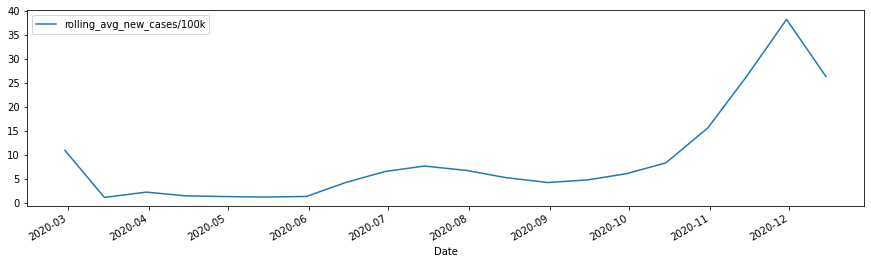

In [ ]:
df_washington_county[["rolling_avg_new_cases/100k"]].plot(figsize=(15,4))


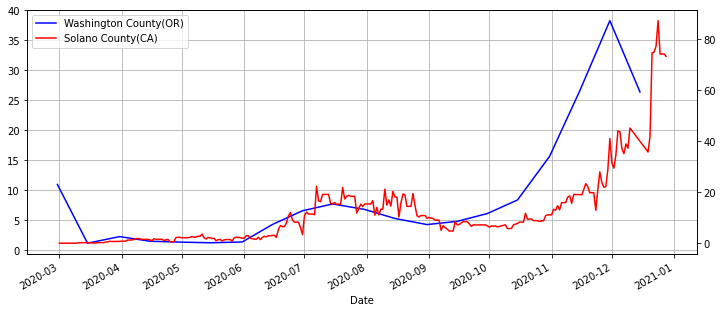

In [ ]:
plt.figure(figsize=(12,5))
plt.xlabel('Number of requests every 10 minutes')

ax1 = df_washington_county["rolling_avg_new_cases/100k"].plot(color='blue', grid=True, label='Washington County(OR)')
ax2 = df_solano_county["rolling_avg_new_cases/100k"].plot(color='red', grid=True, secondary_y=True, label='Solano County(CA)')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

# Extracting 'Placer County'

In [ ]:

df_placer_county = ca_labeled_superset_data[ca_labeled_superset_data['County Name'] == 'Placer County']
print(df_placer_county.shape)
df_placer_county.head(2)

(292, 63)


,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,positivity_rate,rolling_avg_new_cases/100k,daily_growth_range,growth_label
7895,2020-03-01,California,6061,0,Placer County,0.0,5.299,65,9.0,22.0,12.0,2.0,3.0,0.0,104.292831,California,CA,6061,Placer County,6,38,26,2.91,36.6,2.1,37.1,0.25,2.65,0,393149,-6.7,1.17,25,84357,1.5,13.8,48.81,98,156,2.05,0.22,0.0,0.0000,0.0,37,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.000000,0.0,0.0,0.0,minimal
7896,2020-03-02,California,6061,1,Placer County,0.0,7.577,93,7.0,16.0,16.0,5.0,2.0,0.0,104.292831,California,CA,6061,Placer County,6,15,18,3.46,35.4,1.7,41.8,0.67,2.78,1,393149,-2.2,1.17,25,84357,1.5,13.8,48.81,98,156,2.05,0.22,0.0,0.0008,0.0,0,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.254356,0.0,0.0,0.0,minimal


In [ ]:
df_placer_county.index = pd.to_datetime(df_placer_county["Date"])

df_placer_county.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,positivity_rate,rolling_avg_new_cases/100k,daily_growth_range,growth_label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-01,2020-03-01,California,6061,0,Placer County,0.0,5.299,65,9.0,22.0,12.0,2.0,3.0,0.0,104.292831,California,CA,6061,Placer County,6,38,26,2.91,36.6,2.1,37.1,0.25,2.65,0,393149,-6.7,1.17,25,84357,1.5,13.8,48.81,98,156,2.05,0.22,0.0,0.0000,0.0,37,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.000000,0.0,0.0,0.0,minimal
2020-03-02,2020-03-02,California,6061,1,Placer County,0.0,7.577,93,7.0,16.0,16.0,5.0,2.0,0.0,104.292831,California,CA,6061,Placer County,6,15,18,3.46,35.4,1.7,41.8,0.67,2.78,1,393149,-2.2,1.17,25,84357,1.5,13.8,48.81,98,156,2.05,0.22,0.0,0.0008,0.0,0,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.254356,0.0,0.0,0.0,minimal


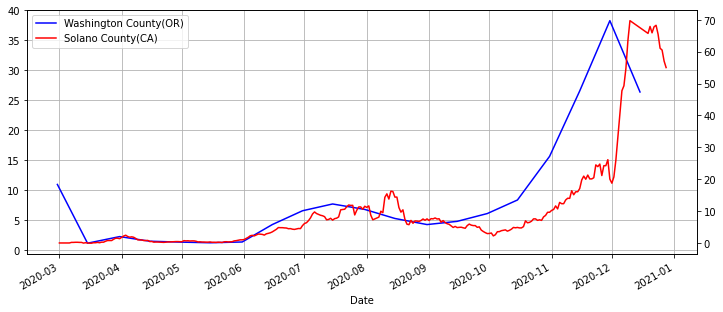

In [ ]:
plt.figure(figsize=(12,5))
plt.xlabel('Number of requests every 10 minutes')

ax1 = df_washington_county["rolling_avg_new_cases/100k"].plot(color='blue', grid=True, label='Washington County(OR)')
ax2 = df_placer_county["rolling_avg_new_cases/100k"].plot(color='red', grid=True, secondary_y=True, label='Solano County(CA)')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

In [ ]:
df_washington_county_minimal = df_washington_county[df_washington_county['growth_label'] == 'minimal']
df_washington_county_nc = df_washington_county[df_washington_county['growth_label'] == 'nochange']
df_washington_county_widespread = df_washington_county[df_washington_county['growth_label'] == 'widespread']

In [ ]:
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'

OR_labeled = pd.read_csv(location+'OR_SuperData_With_SimilarityScore_Mar04.csv',low_memory=False)
OR_labeled.head(5)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate,growth_label,similiary_score
0,2020-02-29,Oregon,41031.0,0.000000,Jefferson County,0.0,9.719966,92.366460,12.571429,8.857143,0.0,2.785714,0.285714,-0.928571,5.013675,Oregon,OR,41031.0,Jefferson County,41.0,20.571429,20.071429,3.756429,30.650000,1.528571,40.892857,0.534286,3.220714,0.000000,24192.0,10.514286,1.08,26.0,50339.0,0.9,20.0,51.89,4.0,102.0,2.2,0.2,0.024,0.000000,0.002143,43.500000,48.812683,5.992857,0.035714,0.025714,0.214286,0.000000,0.061429,0.000000,1.000000,3.300000,7.250000,0.600000,0.000000,0.000000,0.433903,0.000000,nochange,"(301, array([[0.99477784]]))"
1,2020-03-15,Oregon,41031.0,0.000000,Jefferson County,0.0,4.678473,39.923913,-23.750000,4.187500,0.0,-6.500000,-27.750000,0.000000,5.013675,Oregon,OR,41031.0,Jefferson County,41.0,32.812500,25.000000,3.389375,27.618750,1.418750,34.625000,0.463750,2.923750,0.000000,24192.0,0.325000,1.08,26.0,50339.0,0.9,20.0,51.89,4.0,102.0,2.2,0.2,0.024,0.000000,0.055000,58.500000,49.306294,5.418750,1.125000,1.244375,9.562500,0.812500,0.046250,3.062500,8.468750,6.643750,23.131250,0.600000,3.675000,0.000000,0.000000,0.000000,nochange,"(13669, array([[0.98887557]]))"
2,2020-03-31,Oregon,41031.0,0.066667,Jefferson County,0.0,2.951667,25.124638,-13.533333,1.266667,0.0,-7.466667,-38.000000,0.000000,5.013675,Oregon,OR,41031.0,Jefferson County,41.0,36.333333,26.000000,3.308000,27.266667,1.240000,30.706667,0.456667,2.852000,0.066667,24192.0,-2.133333,1.08,26.0,50339.0,0.9,20.0,51.89,4.0,102.0,2.2,0.2,0.024,0.000920,0.264000,68.600000,50.132514,5.160000,5.416667,5.640667,25.933333,3.600000,0.060667,18.200000,11.873333,13.086667,26.306667,0.226667,12.996000,0.275573,0.239629,0.000017,nochange,"(2570, array([[0.9737712]]))"
3,2020-04-15,Oregon,41031.0,0.642857,Jefferson County,0.0,3.944196,34.096273,0.000000,0.000000,0.0,0.714286,-36.214286,0.000000,5.013675,Oregon,OR,41031.0,Jefferson County,41.0,27.214286,23.071429,3.475714,31.607143,1.542857,36.592857,0.430000,3.046429,0.642857,24192.0,4.535714,1.08,26.0,50339.0,0.9,20.0,51.89,4.0,102.0,2.2,0.2,0.024,0.020671,0.420714,0.714286,50.062779,4.814286,10.334286,8.497143,25.785714,7.285714,0.092857,33.500000,10.242857,14.614286,28.185714,0.200000,20.927857,2.657313,2.541778,0.000200,nochange,"(2590, array([[0.9860505]]))"
4,2020-04-30,Oregon,41031.0,0.933333,Jefferson County,0.0,5.828539,52.971014,-0.533333,0.000000,0.0,4.000000,-34.666667,0.000000,5.013675,Oregon,OR,41031.0,Jefferson County,41.0,23.000000,20.733333,3.489333,35.166667,1.833333,40.080000,0.386667,3.102000,0.933333,24192.0,6.433333,1.08,26.0,50339.0,0.9,20.0,51.89,4.0,102.0,2.2,0.2,0.024,0.045927,0.422000,0.266667,49.811245,4.266667,16.700667,5.338000,20.600000,8.266667,0.154667,48.066667,7.473333,14.186667,29.866667,0.200000

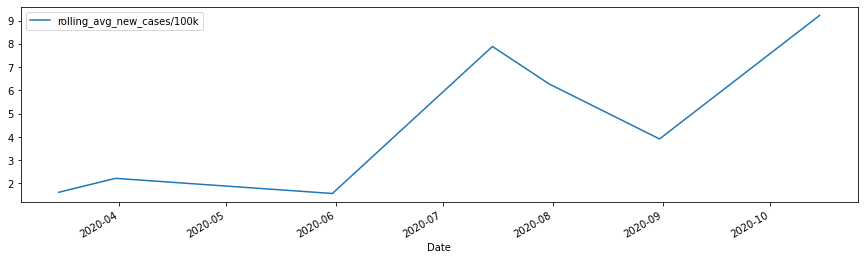

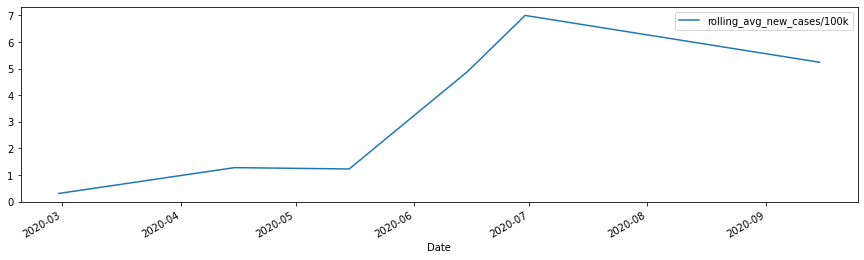

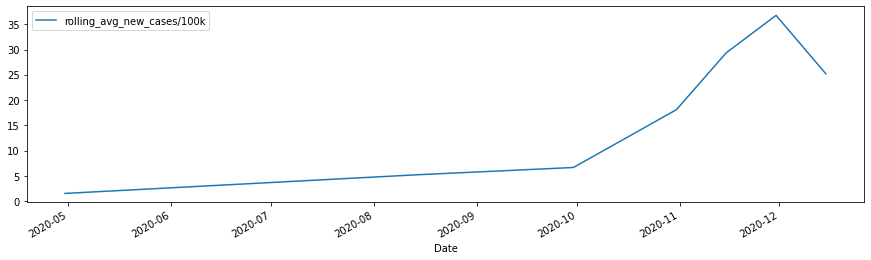

In [ ]:
#df_washington_county.plot(figsize=(15,4))
#df_washington_county.plot(subplots=True, figsize=(15,6))
#df_washington_county_minimal.plot(y=["rolling_avg_new_cases/100k"], figsize=(15,4))
#df_washington_county_nc.plot(y=["rolling_avg_new_cases/100k"], figsize=(15,4))
df_washington_county_minimal[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))
df_washington_county_nc[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))

df_washington_county_widespread[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))


#df.plot(x="R", y=["F10.7", "Dst"], style='.')

In [ ]:
df_Multnomah_County = or_bin_superset_data[or_bin_superset_data['County Name'] == 'Multnomah County']
df_Multnomah_County.head()

NameError: ignored

In [ ]:
df_Multnomah_County.index = pd.to_datetime(df_Multnomah_County["Date"])

df_Multnomah_County.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate,growth_label,similiary_score
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-29,2020-02-29,Oregon,41051.0,0.071429,Multnomah County,0.0,4.281643,84.857143,2.071429,7.285714,25.500,-2.5000,-1.285714,0.928571,715.275377,Oregon,OR,41051.0,Multnomah County,41.0,23.714286,24.214286,3.540000,32.857143,10.842857,35.478571,0.495000,3.042143,0.071429,811880.0,0.814286,11.61,18.0,64337.0,5.3,11.4,49.54,1180.0,185.0,2.2,0.2,0.024,0.000086,0.002143,29.642857,48.812683,5.992857,0.035714,0.025714,0.214286,4.357143,0.061429,0.0000,1.00000,3.30000,7.25000,0.6,0.000,0.008798,0.008798,0.000240,nochange,"(3407, [[0.984405556316313]])"
2020-03-15,2020-03-15,Oregon,41051.0,6.187500,Multnomah County,0.0,0.792187,15.250000,-46.625000,-10.687500,12.375,-46.0625,-41.937500,15.812500,715.275377,Oregon,OR,41051.0,Multnomah County,41.0,52.500000,38.000000,2.869375,29.387500,9.493750,25.856250,0.365625,2.504375,6.187500,811880.0,-16.981250,11.61,18.0,64337.0,5.3,11.4,49.54,1180.0,185.0,2.2,0.2,0.024,0.006900,0.055000,0.000000,49.306294,5.418750,1.125000,1.244375,9.562500,43.687500,0.046250,3.0625,8.46875,6.64375,23.13125,0.6,3.675,0.762120,0.481686,0.000613,minimal,"(8723, [[0.9665898295469391]])"


In [ ]:
df_Multnomah_County_minimal = df_Multnomah_County[df_Multnomah_County['growth_label'] == 'minimal']
df_Multnomah_County_nc = df_Multnomah_County[df_Multnomah_County['growth_label'] == 'nochange']
df_Multnomah_County_widespread = df_Multnomah_County[df_Multnomah_County['growth_label'] == 'widespread']

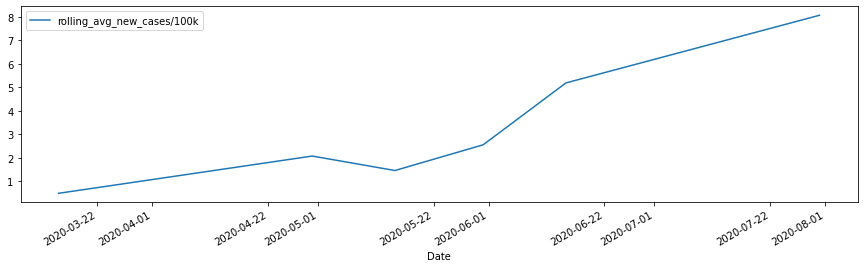

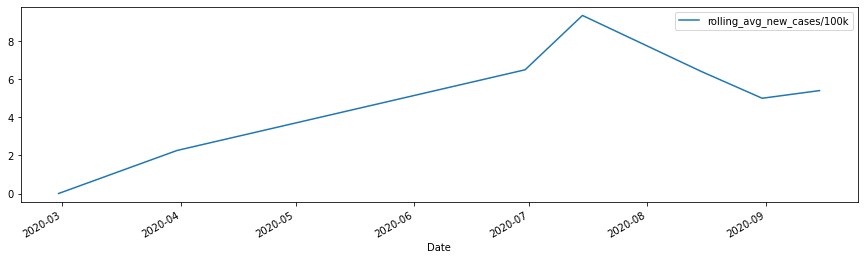

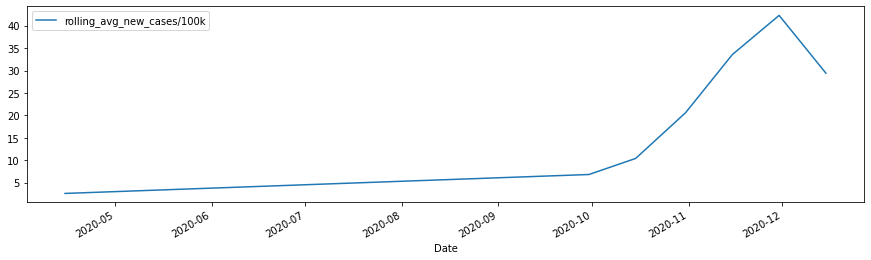

In [ ]:
df_Multnomah_County_minimal[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))
df_Multnomah_County_nc[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))

df_Multnomah_County_widespread[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))

# Using Selected Demographic Columns

## Column Mapping

In [ ]:
ca_labeled_superset_data.columns

Index(['Date', 'Province_State', 'FIPS', 'New cases', 'County Name',
       'mask_rule_severity', 'm50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'PopDensity', 'State_Name',
       'State', 'CTFIPS', 'CTNAME', 'STFIPS', 'Social.distancing.index',
       'X..staying.home', 'Trips.person', 'X..out.of.county.trips',
       'X..out.of.state.trips', 'Miles.person', 'Work.trips.person',
       'Non.work.trips.person', 'New.COVID.cases', 'Population',
       'X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Employment.density',
       'X..hot.spots.1000.people', 'Hospital.beds.1000.peop

In [ ]:
or_bin_superset_data.columns

Index(['Date', 'Province_State', 'FIPS', 'New cases', 'County Name',
       'mask_rule_severity', 'm50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'PopDensity', 'State_Name',
       'State', 'CTFIPS', 'CTNAME', 'STFIPS', 'Social.distancing.index',
       'X..staying.home', 'Trips.person', 'X..out.of.county.trips',
       'X..out.of.state.trips', 'Miles.person', 'Work.trips.person',
       'Non.work.trips.person', 'New.COVID.cases', 'Population',
       'X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Employment.density',
       'X..hot.spots.1000.people', 'Hospital.beds.1000.peop

In [ ]:
or_bin_superset_data.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate
0,2020-02-29,Oregon,41031.0,0.0,Jefferson County,0.0,9.719966,92.366460,12.571429,8.857143,0.0,2.785714,0.285714,-0.928571,5.013675,Oregon,OR,41031.0,Jefferson County,41.0,20.571429,20.071429,3.756429,30.65000,1.528571,40.892857,0.534286,3.220714,0.0,24192.0,10.514286,1.08,26.0,50339.0,0.9,20.0,51.89,4.0,102.0,2.2,0.2,0.024,0.0,0.002143,43.5,48.812683,5.992857,0.035714,0.025714,0.214286,0.0000,0.061429,0.0000,1.00000,3.30000,7.25000,0.6,0.000,0.0,0.433903,0.0
1,2020-03-15,Oregon,41031.0,0.0,Jefferson County,0.0,4.678473,39.923913,-23.750000,4.187500,0.0,-6.500000,-27.750000,0.000000,5.013675,Oregon,OR,41031.0,Jefferson County,41.0,32.812500,25.000000,3.389375,27.61875,1.418750,34.625000,0.463750,2.923750,0.0,24192.0,0.325000,1.08,26.0,50339.0,0.9,20.0,51.89,4.0,102.0,2.2,0.2,0.024,0.0,0.055000,58.5,49.306294,5.418750,1.125000,1.244375,9.562500,0.8125,0.046250,3.0625,8.46875,6.64375,23.13125,0.6,3.675,0.0,0.000000,0.0


'Province_State', 'FIPS', 'County Name','PopDensity', 'State_Name','State', 'CTFIPS', 'CTNAME', 'STFIPS',
'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Employment.density','Testing.capacity', 'Ventilator.shortage','Unemployment.rate','Unemployment.claims.1000.people',

In [ ]:
demographic_cols = [ 'FIPS', 'County Name', 'PopDensity', #'STFIPS', # remove FIPS also during knn
                 'X..people.older.than.60', 'Median.income', 
                 'X..African.Americans', 'X..Hispanic.Americans',
                  'X..Male', 'Employment.density','Testing.capacity',
                 'Ventilator.shortage','Unemployment.rate','Unemployment.claims.1000.people']

# TODO:
* filter each county
* check how each column of demographic is varying - std.dev
* std.dev is zero -> Eg., Pop.Density
* std.dev less -> mean
* std.dev is too high -> we will use worst case like min() or max() 

**Summary**: The latent features (loc2vec features ) describe the probalistic causal behaviour of the pandemic. The features are responsible for describing the sudden increase or surge of the pandemic. The counties with closest 

* Surge in LA -> Surge in WA county in OR


#### Analysis: Demographic Column Mapping for OR(County wise)

In [ ]:
or_bin_superset_data_filtered = or_bin_superset_data[demographic_cols]

In [ ]:
or_bin_superset_data_filtered.head(2)

,FIPS,County Name,PopDensity,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Ventilator.shortage,Unemployment.rate,Unemployment.claims.1000.people
0,41031.0,Jefferson County,5.013675,26.0,50339.0,0.9,20.0,51.89,4.0,5.992857,0.214286,3.30000,1.00000
1,41031.0,Jefferson County,5.013675,26.0,50339.0,0.9,20.0,51.89,4.0,5.418750,9.562500,6.64375,8.46875


In [ ]:
or_bin_superset_data_filtered['FIPS'].unique()

array([41031., 41037., 41041., 41003., 41029., 41047., 41053., 41061.,
       41067., 41019., 41023., 41009., 41043., 41001., 41005., 41007.,
       41011., 41013., 41015., 41017., 41027., 41033., 41035., 41039.,
       41045., 41049., 41051., 41055., 41057., 41059., 41065., 41071.])

In [ ]:
or_bin_superset_data_filtered['County Name'].unique()

array(['Jefferson County', 'Lake County', 'Lincoln County',
       'Benton County', 'Jackson County', 'Marion County', 'Polk County',
       'Union County', 'Washington County', 'Douglas County',
       'Grant County', 'Columbia County', 'Linn County', 'Baker County',
       'Clackamas County', 'Clatsop County', 'Coos County',
       'Crook County', 'Curry County', 'Deschutes County',
       'Hood River County', 'Josephine County', 'Klamath County',
       'Lane County', 'Malheur County', 'Morrow County',
       'Multnomah County', 'Sherman County', 'Tillamook County',
       'Umatilla County', 'Wasco County', 'Yamhill County'], dtype=object)

In [ ]:
or_fips_list= list(or_bin_superset_data_filtered['FIPS'].unique())
or_county_list= list(or_bin_superset_data_filtered['County Name'].unique())
len(or_fips_list)

32

In [ ]:
or_bin_superset_data_filtered[or_bin_superset_data_filtered['County Name']=='Jefferson County'].describe().T

,count,mean,std,min,25%,50%,75%,max
FIPS,20.0,41031.000000,0.000000e+00,41031.000000,41031.000000,41031.000000,41031.000000,41031.000000
PopDensity,20.0,5.013675,7.073216e-15,5.013675,5.013675,5.013675,5.013675,5.013675
X..people.older.than.60,20.0,26.000000,0.000000e+00,26.000000,26.000000,26.000000,26.000000,26.000000
Median.income,20.0,50339.000000,0.000000e+00,50339.000000,50339.000000,50339.000000,50339.000000,50339.000000
X..African.Americans,20.0,0.900000,1.586534e-15,0.900000,0.900000,0.900000,0.900000,0.900000
X..Hispanic.Americans,20.0,20.000000,0.000000e+00,20.000000,20.000000,20.000000,20.000000,20.000000
X..Male,20.0,51.890000,8.728251e-14,51.890000,51.890000,51.890000,51.890000,51.890000
Employment.density,20.0,4.000000,0.000000e+00,4.000000,4.000000,4.000000,4.000000,4.000000
Testing.capacity,20.0,4.710101,8.082706e-01,3.220000,4.260000,4.775000,5.096250,6.466667
Ventilator.shortage,20.0,27.081916,2.064876e+01,0.214286,14.712500,19.933333,26.533333,78.500000


In [ ]:
or_bin_superset_data_filtered[or_bin_superset_data_filtered['County Name']=='Washington County'].describe().T

,count,mean,std,min,25%,50%,75%,max
FIPS,20.0,41067.000000,0.000000e+00,41067.000000,41067.000000,41067.000000,41067.000000,41067.000000
PopDensity,20.0,310.164459,4.197428e-13,310.164459,310.164459,310.164459,310.164459,310.164459
X..people.older.than.60,20.0,18.000000,0.000000e+00,18.000000,18.000000,18.000000,18.000000,18.000000
Median.income,20.0,78010.000000,0.000000e+00,78010.000000,78010.000000,78010.000000,78010.000000,78010.000000
X..African.Americans,20.0,1.900000,1.289711e-15,1.900000,1.900000,1.900000,1.900000,1.900000
X..Hispanic.Americans,20.0,16.500000,0.000000e+00,16.500000,16.500000,16.500000,16.500000,16.500000
X..Male,20.0,49.420000,1.334391e-13,49.420000,49.420000,49.420000,49.420000,49.420000
Employment.density,20.0,354.000000,0.000000e+00,354.000000,354.000000,354.000000,354.000000,354.000000
Testing.capacity,20.0,4.711542,8.073331e-01,3.220000,4.260000,4.796875,5.096322,6.466667
Ventilator.shortage,20.0,25.535012,1.708735e+01,0.207692,15.532143,19.933333,26.520534,65.500000


##### Decisions after Observation and Analysis
* filter each county
* check how each column of demographic is varying - std.dev
* std.dev is zero -> Eg., Pop.Density
* std.dev less -> mean
* std.dev is too high -> we will use worst case like min() or max() 

* **Decisions after Observation and Analysis** :
> * std.dev is zero for these columns: [X..people.older.than.60,Median.income, X..Hispanic.Americans,Employment.density]; Hence taking the columns values as it is.
> * worst case scenerios for these columns [ 'Testing.capacity' (min),'Ventilator.shortage' (?max),'Unemployment.rate'(max),'Unemployment.claims.1000.people'(max)] -#columns that are somewhat related to pandemic
> * Removed Median Income, adding this was causing some issues, all the OR counties were mapping to Santa Clara County only

In [ ]:
or_bin_superset_data_filtered.columns

Index(['FIPS', 'County Name', 'PopDensity', 'X..people.older.than.60',
       'Median.income', 'X..African.Americans', 'X..Hispanic.Americans',
       'X..Male', 'Employment.density', 'Testing.capacity',
       'Ventilator.shortage', 'Unemployment.rate',
       'Unemployment.claims.1000.people'],
      dtype='object')

In [ ]:
or_county_list = or_bin_superset_data_filtered['County Name'].unique()

In [ ]:
#for county in or_county_list:
value_list = []
value_list_with_county = []
for i in range(0, len(or_county_list)):
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  #print("county",or_county_list[i])
  #print(or_bin_superset_data_filtered[or_bin_superset_data_filtered['County Name']==or_county_list[i]].describe().T)
  #print("******************************************")
  #or_bin_superset_data_filtered[or_bin_superset_data_filtered['County Name']=='Jefferson County'].describe().T
  temp_df = or_bin_superset_data_filtered[or_bin_superset_data_filtered['County Name']==or_county_list[i]]
  
  ################################1
  PopDensity =0
  if temp_df['PopDensity'].std() == 0.0:
    PopDensity = temp_df['PopDensity'].mean()
  if temp_df['PopDensity'].std() < 0:
    PopDensity = temp_df['PopDensity'].mean()
  if temp_df['PopDensity'].std() > 0: #and temp_df['PopDensity'].std() < 100:
    PopDensity = temp_df['PopDensity'].mean()
  ################################2
  X_people_older_than_60 =0
  if temp_df['X..people.older.than.60'].std() == 0.0:
    X_people_older_than_60 = temp_df['X..people.older.than.60'].mean()
  if temp_df['X..people.older.than.60'].std() < 0:
    X_people_older_than_60 = temp_df['X..people.older.than.60'].mean()
  if temp_df['X..people.older.than.60'].std() > 0: # and temp_df['X..people.older.than.60'].std() < 100:
    X_people_older_than_60 = temp_df['X..people.older.than.60'].mean()
  ################################3
  Median_income =0
  if temp_df['Median.income'].std() == 0.0:
    Median_income = temp_df['Median.income'].mean()
  if temp_df['Median.income'].std() < 0:
    Median_income = temp_df['Median.income'].mean()
  if temp_df['Median.income'].std() > 0: # and temp_df['X..people.older.than.60'].std() < 100:
    Median_income = temp_df['Median.income'].mean()
  ################################4
  X_African_Americans =0
  if temp_df['X..African.Americans'].std() == 0.0:
    X_African_Americans = temp_df['X..African.Americans'].mean()
  if temp_df['X..African.Americans'].std() < 0:
    X_African_Americans = temp_df['X..African.Americans'].mean()
  if temp_df['X..African.Americans'].std() > 0: # and temp_df['X..people.older.than.60'].std() < 100:
    X_African_Americans = temp_df['X..African.Americans'].mean()
  ################################5
  X_Hispanic_Americans =0
  if temp_df['X..Hispanic.Americans'].std() == 0.0:
    X_Hispanic_Americans = temp_df['X..Hispanic.Americans'].mean()
  if temp_df['X..Hispanic.Americans'].std() < 0:
    X_Hispanic_Americans = temp_df['X..Hispanic.Americans'].mean()
  if temp_df['X..Hispanic.Americans'].std() > 0: # and temp_df['X..people.older.than.60'].std() < 100:
    X_Hispanic_Americans = temp_df['X..Hispanic.Americans'].mean()
  ################################6
  X_Male =0
  if temp_df['X..Male'].std() == 0.0:
    X_Male = temp_df['X..Male'].mean()
  if temp_df['X..Male'].std() < 0:
    X_Male = temp_df['X..Male'].mean()
  if temp_df['X..Male'].std() > 0: # and temp_df['X..people.older.than.60'].std() < 100:
    X_Male = temp_df['X..Male'].mean()
  ################################7
  Employment_density =0
  if temp_df['Employment.density'].std() == 0.0:
    Employment_density = temp_df['Employment.density'].mean()
  if temp_df['Employment.density'].std() < 0:
    Employment_density = temp_df['Employment.density'].mean()
  if temp_df['Employment.density'].std() > 0: # and temp_df['X..people.older.than.60'].std() < 100:
    Employment_density = temp_df['Employment.density'].mean()
  ####################################
  #columns that are somewhat related to pandemic
  ####################################8
  Testing_capacity =0
  if temp_df['Testing.capacity'].std() == 0.0:
    Testing_capacity = temp_df['Testing.capacity'].mean()
  if temp_df['Testing.capacity'].std() < 0:
    Testing_capacity = temp_df['Testing.capacity'].mean()
  if temp_df['Testing.capacity'].std() > 0 and temp_df['Testing.capacity'].std() < 100:
    Testing_capacity = temp_df['Testing.capacity'].mean()
  if temp_df['Testing.capacity'].std() > 100:
    Testing_capacity = temp_df['Testing.capacity'].min() #worst case
  ####################################9
  Ventilator_shortage =0
  if temp_df['Ventilator.shortage'].std() == 0.0:
    Ventilator_shortage = temp_df['Ventilator.shortage'].mean()
  if temp_df['Ventilator.shortage'].std() < 0:
    Ventilator_shortage = temp_df['Ventilator.shortage'].mean()
  if temp_df['Ventilator.shortage'].std() > 0 and temp_df['Ventilator.shortage'].std() < 100:
    Ventilator_shortage = temp_df['Ventilator.shortage'].mean()
  if temp_df['Ventilator.shortage'].std() > 100:
    Ventilator_shortage = temp_df['Ventilator.shortage'].max() #worst case #scs-has doubt
  ####################################10
  Unemployment_rate =0
  if temp_df['Unemployment.rate'].std() == 0.0:
    Unemployment_rate = temp_df['Unemployment.rate'].mean()
  if temp_df['Unemployment.rate'].std() < 0:
    Unemployment_rate = temp_df['Unemployment.rate'].mean()
  if temp_df['Unemployment.rate'].std() > 0 and temp_df['Unemployment.rate'].std() < 100:
    Unemployment_rate = temp_df['Unemployment.rate'].mean()
  if temp_df['Unemployment.rate'].std() > 100:
    Unemployment_rate = temp_df['Unemployment.rate'].max() #worst case 
  ####################################11
  Unemployment_claims_1000_people =0
  if temp_df['Unemployment.claims.1000.people'].std() == 0.0:
    Unemployment_claims_1000_people = temp_df['Unemployment.claims.1000.people'].mean()
  if temp_df['Unemployment.claims.1000.people'].std() < 0:
    Unemployment_claims_1000_people = temp_df['Unemployment.claims.1000.people'].mean()
  if temp_df['Unemployment.claims.1000.people'].std() > 0 and temp_df['Unemployment.claims.1000.people'].std() < 100:
    Unemployment_claims_1000_people = temp_df['Unemployment.claims.1000.people'].mean()
  if temp_df['Unemployment.claims.1000.people'].std() > 100:
    Unemployment_claims_1000_people = temp_df['Unemployment.claims.1000.people'].max() #worst case
  ####################################
  value_list.append((PopDensity,X_people_older_than_60,#Median_income,
                     X_African_Americans,
                     X_Hispanic_Americans,X_Male,Employment_density,Testing_capacity,
                     Ventilator_shortage,Unemployment_rate,Unemployment_claims_1000_people))
  value_list_with_county.append((*temp_df['FIPS'].unique(),or_county_list[i],PopDensity,X_people_older_than_60,Median_income,X_African_Americans,
                     X_Hispanic_Americans,X_Male,Employment_density,Testing_capacity,
                     Ventilator_shortage,Unemployment_rate,Unemployment_claims_1000_people))

or_knn_df = pd.DataFrame(value_list, columns=('PopDensity', 'X..people.older.than.60',
       #'Median.income',  --temporary
       'X..African.Americans', 'X..Hispanic.Americans',
       'X..Male', 'Employment.density', 'Testing.capacity',
       'Ventilator.shortage', 'Unemployment.rate',
       'Unemployment.claims.1000.people'))
or_knn_df_with_county = pd.DataFrame(value_list_with_county, columns=('FIPS', 'County Name','PopDensity',
                                                                      'X..people.older.than.60',
       'Median.income', 'X..African.Americans', 'X..Hispanic.Americans',
       'X..Male', 'Employment.density', 'Testing.capacity',
       'Ventilator.shortage', 'Unemployment.rate',
       'Unemployment.claims.1000.people'))
print(len(or_knn_df))




32


In [ ]:
print(len(or_knn_df))
or_knn_df.head(2)

32


,PopDensity,X..people.older.than.60,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Ventilator.shortage,Unemployment.rate,Unemployment.claims.1000.people
0,5.013675,26.0,0.9,20.0,51.89,4.0,4.710101,27.081916,9.096906,3.830935
1,0.372079,33.0,0.2,8.0,53.45,1.0,4.699273,24.482247,9.144470,3.957321


In [ ]:
or_knn_df_with_county.head(2)

,FIPS,County Name,PopDensity,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Ventilator.shortage,Unemployment.rate,Unemployment.claims.1000.people
0,41031.0,Jefferson County,5.013675,26.0,50339.0,0.9,20.0,51.89,4.0,4.710101,27.081916,9.096906,3.830935
1,41037.0,Lake County,0.372079,33.0,36627.0,0.2,8.0,53.45,1.0,4.699273,24.482247,9.144470,3.957321


#### Analysis: Demographic Column Mapping for CA(County wise)

In [ ]:
ca_labeled_superset_data_filtered = ca_labeled_superset_data[demographic_cols]

In [ ]:
ca_labeled_superset_data_filtered.head(2)

,FIPS,County Name,PopDensity,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Ventilator.shortage,Unemployment.rate,Unemployment.claims.1000.people
0,6001,Alameda County,860.757075,19,92574,10.5,22.5,49.11,1155,0.0,0,5.3,1.1
1,6001,Alameda County,860.757075,19,92574,10.5,22.5,49.11,1155,0.0,0,5.3,1.1


In [ ]:
ca_labeled_superset_data_filtered['FIPS'].unique()

array([6001, 6005, 6007, 6009, 6011, 6013, 6015, 6017, 6019, 6021, 6023,
       6025, 6027, 6029, 6031, 6033, 6035, 6037, 6039, 6041, 6043, 6045,
       6047, 6051, 6053, 6055, 6057, 6059, 6061, 6063, 6065, 6067, 6069,
       6071, 6073, 6075, 6077, 6079, 6081, 6083, 6085, 6087, 6089, 6093,
       6095, 6097, 6099, 6101, 6103, 6107, 6109, 6111, 6113, 6115])

In [ ]:
ca_labeled_superset_data_filtered['County Name'].unique()

array(['Alameda County', 'Amador County', 'Butte County',
       'Calaveras County', 'Colusa County', 'Contra Costa County',
       'Del Norte County', 'El Dorado County', 'Fresno County',
       'Glenn County', 'Humboldt County', 'Imperial County',
       'Inyo County', 'Kern County', 'Kings County', 'Lake County',
       'Lassen County', 'Los Angeles County', 'Madera County',
       'Marin County', 'Mariposa County', 'Mendocino County',
       'Merced County', 'Mono County', 'Monterey County', 'Napa County',
       'Nevada County', 'Orange County', 'Placer County', 'Plumas County',
       'Riverside County', 'Sacramento County', 'San Benito County',
       'San Bernardino County', 'San Diego County',
       'San Francisco County', 'San Joaquin County',
       'San Luis Obispo County', 'San Mateo County',
       'Santa Barbara County', 'Santa Clara County', 'Santa Cruz County',
       'Shasta County', 'Siskiyou County', 'Solano County',
       'Sonoma County', 'Stanislaus County', 'Su

In [ ]:
ca_fips_list= list(ca_labeled_superset_data_filtered['FIPS'].unique())
ca_county_list= list(ca_labeled_superset_data_filtered['County Name'].unique())
len(ca_fips_list)

54

In [ ]:
ca_labeled_superset_data_filtered[ca_labeled_superset_data_filtered['County Name']=='Solano County'].describe().T

,count,mean,std,min,25%,50%,75%,max
FIPS,292.0,6095.000000,0.000000e+00,6095.000000,6095.000000,6095.000000,6095.000000,6095.000000
PopDensity,292.0,206.044406,4.555280e-13,206.044406,206.044406,206.044406,206.044406,206.044406
X..people.older.than.60,292.0,21.000000,0.000000e+00,21.000000,21.000000,21.000000,21.000000,21.000000
Median.income,292.0,77609.000000,0.000000e+00,77609.000000,77609.000000,77609.000000,77609.000000,77609.000000
X..African.Americans,292.0,13.600000,6.227922e-14,13.600000,13.600000,13.600000,13.600000,13.600000
X..Hispanic.Americans,292.0,26.100000,1.352349e-13,26.100000,26.100000,26.100000,26.100000,26.100000
X..Male,292.0,49.700000,2.419993e-13,49.700000,49.700000,49.700000,49.700000,49.700000
Employment.density,292.0,180.000000,0.000000e+00,180.000000,180.000000,180.000000,180.000000,180.000000
Testing.capacity,292.0,7.159589,4.039574e+00,0.000000,5.300000,6.000000,6.600000,30.300000
Ventilator.shortage,292.0,632.784247,4.740710e+02,0.000000,363.250000,601.500000,685.250000,2902.000000


In [ ]:
ca_labeled_superset_data_filtered[ca_labeled_superset_data_filtered['County Name']=='Los Angeles County'].describe().T

,count,mean,std,min,25%,50%,75%,max
FIPS,292.0,6037.000000,0.000000e+00,6037.000000,6037.000000,6037.000000,6037.000000,6037.000000
PopDensity,292.0,960.742778,5.124690e-12,960.742778,960.742778,960.742778,960.742778,960.742778
X..people.older.than.60,292.0,18.000000,0.000000e+00,18.000000,18.000000,18.000000,18.000000,18.000000
Median.income,292.0,64251.000000,0.000000e+00,64251.000000,64251.000000,64251.000000,64251.000000,64251.000000
X..African.Americans,292.0,7.900000,4.270575e-14,7.900000,7.900000,7.900000,7.900000,7.900000
X..Hispanic.Americans,292.0,48.500000,0.000000e+00,48.500000,48.500000,48.500000,48.500000,48.500000
X..Male,292.0,49.280000,2.348816e-13,49.280000,49.280000,49.280000,49.280000,49.280000
Employment.density,292.0,972.000000,0.000000e+00,972.000000,972.000000,972.000000,972.000000,972.000000
Testing.capacity,292.0,7.159589,4.039574e+00,0.000000,5.300000,6.000000,6.600000,30.300000
Ventilator.shortage,292.0,632.784247,4.740710e+02,0.000000,363.250000,601.500000,685.250000,2902.000000


##### Decisions after Observation and Analysis 

* filter each county
* check how each column of demographic is varying - std.dev
* std.dev is zero -> Eg., Pop.Density
* std.dev less -> mean
* std.dev is too high -> we will use worst case like min() or max() 

* **Decisions after Observation and Analysis** :
> * std.dev is zero for these columns: [X..people.older.than.60,Median.income, Employment.density]; Hence taking the columns values as it is.
> * worst case scenerios for these columns [ 'Testing.capacity' (min),'Ventilator.shortage' (?max),'Unemployment.rate'(max),'Unemployment.claims.1000.people'(max)] -#columns that are somewhat related to pandemic

In [ ]:
print(len(ca_labeled_superset_data_filtered))
print(len(ca_county_list))

15391
54


In [ ]:
ca_labeled_superset_data_filtered.columns

Index(['FIPS', 'County Name', 'PopDensity', 'X..people.older.than.60',
       'Median.income', 'X..African.Americans', 'X..Hispanic.Americans',
       'X..Male', 'Employment.density', 'Testing.capacity',
       'Ventilator.shortage', 'Unemployment.rate',
       'Unemployment.claims.1000.people'],
      dtype='object')

In [ ]:
#for county in or_county_list:
value_list = []
value_list_with_county = []
for i in range(0, len(ca_county_list)):
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  #print("county",or_county_list[i])
  #print(or_bin_superset_data_filtered[or_bin_superset_data_filtered['County Name']==or_county_list[i]].describe().T)
  #print("******************************************")
  #or_bin_superset_data_filtered[or_bin_superset_data_filtered['County Name']=='Jefferson County'].describe().T
  temp_df = ca_labeled_superset_data_filtered[ca_labeled_superset_data_filtered['County Name']==ca_county_list[i]]
  
  ################################1
  PopDensity =0
  if temp_df['PopDensity'].std() == 0.0:
    PopDensity = temp_df['PopDensity'].mean()
  if temp_df['PopDensity'].std() < 0:
    PopDensity = temp_df['PopDensity'].mean()
  if temp_df['PopDensity'].std() > 0: #and temp_df['PopDensity'].std() < 100:
    PopDensity = temp_df['PopDensity'].mean()
  ################################2
  X_people_older_than_60 =0
  if temp_df['X..people.older.than.60'].std() == 0.0:
    X_people_older_than_60 = temp_df['X..people.older.than.60'].mean()
  if temp_df['X..people.older.than.60'].std() < 0:
    X_people_older_than_60 = temp_df['X..people.older.than.60'].mean()
  if temp_df['X..people.older.than.60'].std() > 0: # and temp_df['X..people.older.than.60'].std() < 100:
    X_people_older_than_60 = temp_df['X..people.older.than.60'].mean()
  ################################3
  Median_income =0
  if temp_df['Median.income'].std() == 0.0:
    Median_income = temp_df['Median.income'].mean()
  if temp_df['Median.income'].std() < 0:
    Median_income = temp_df['Median.income'].mean()
  if temp_df['Median.income'].std() > 0: # and temp_df['X..people.older.than.60'].std() < 100:
    Median_income = temp_df['Median.income'].mean()
  ################################4
  X_African_Americans =0
  if temp_df['X..African.Americans'].std() == 0.0:
    X_African_Americans = temp_df['X..African.Americans'].mean()
  if temp_df['X..African.Americans'].std() < 0:
    X_African_Americans = temp_df['X..African.Americans'].mean()
  if temp_df['X..African.Americans'].std() > 0: # and temp_df['X..people.older.than.60'].std() < 100:
    X_African_Americans = temp_df['X..African.Americans'].mean()
  ################################5
  X_Hispanic_Americans =0
  if temp_df['X..Hispanic.Americans'].std() == 0.0:
    X_Hispanic_Americans = temp_df['X..Hispanic.Americans'].mean()
  if temp_df['X..Hispanic.Americans'].std() < 0:
    X_Hispanic_Americans = temp_df['X..Hispanic.Americans'].mean()
  if temp_df['X..Hispanic.Americans'].std() > 0: # and temp_df['X..people.older.than.60'].std() < 100:
    X_Hispanic_Americans = temp_df['X..Hispanic.Americans'].mean()
  ################################6
  X_Male =0
  if temp_df['X..Male'].std() == 0.0:
    X_Male = temp_df['X..Male'].mean()
  if temp_df['X..Male'].std() < 0:
    X_Male = temp_df['X..Male'].mean()
  if temp_df['X..Male'].std() > 0: # and temp_df['X..people.older.than.60'].std() < 100:
    X_Male = temp_df['X..Male'].mean()
  ################################7
  Employment_density =0
  if temp_df['Employment.density'].std() == 0.0:
    Employment_density = temp_df['Employment.density'].mean()
  if temp_df['Employment.density'].std() < 0:
    Employment_density = temp_df['Employment.density'].mean()
  if temp_df['Employment.density'].std() > 0: # and temp_df['X..people.older.than.60'].std() < 100:
    Employment_density = temp_df['Employment.density'].mean()
  ####################################
  #columns that are somewhat related to pandemic
  ####################################8
  Testing_capacity =0
  if temp_df['Testing.capacity'].std() == 0.0:
    Testing_capacity = temp_df['Testing.capacity'].mean()
  if temp_df['Testing.capacity'].std() < 0:
    Testing_capacity = temp_df['Testing.capacity'].mean()
  if temp_df['Testing.capacity'].std() > 0 and temp_df['Testing.capacity'].std() < 100:
    Testing_capacity = temp_df['Testing.capacity'].mean()
  if temp_df['Testing.capacity'].std() > 100:
    Testing_capacity = temp_df['Testing.capacity'].min() #worst case
  ####################################9
  Ventilator_shortage =0
  if temp_df['Ventilator.shortage'].std() == 0.0:
    Ventilator_shortage = temp_df['Ventilator.shortage'].mean()
  if temp_df['Ventilator.shortage'].std() < 0:
    Ventilator_shortage = temp_df['Ventilator.shortage'].mean()
  if temp_df['Ventilator.shortage'].std() > 0 and temp_df['Ventilator.shortage'].std() < 100:
    Ventilator_shortage = temp_df['Ventilator.shortage'].mean()
  if temp_df['Ventilator.shortage'].std() > 100:
    Ventilator_shortage = temp_df['Ventilator.shortage'].max() #worst case #scs-has doubt
  ####################################10
  Unemployment_rate =0
  if temp_df['Unemployment.rate'].std() == 0.0:
    Unemployment_rate = temp_df['Unemployment.rate'].mean()
  if temp_df['Unemployment.rate'].std() < 0:
    Unemployment_rate = temp_df['Unemployment.rate'].mean()
  if temp_df['Unemployment.rate'].std() > 0 and temp_df['Unemployment.rate'].std() < 100:
    Unemployment_rate = temp_df['Unemployment.rate'].mean()
  if temp_df['Unemployment.rate'].std() > 100:
    Unemployment_rate = temp_df['Unemployment.rate'].max() #worst case 
  ####################################11
  Unemployment_claims_1000_people =0
  if temp_df['Unemployment.claims.1000.people'].std() == 0.0:
    Unemployment_claims_1000_people = temp_df['Unemployment.claims.1000.people'].mean()
  if temp_df['Unemployment.claims.1000.people'].std() < 0:
    Unemployment_claims_1000_people = temp_df['Unemployment.claims.1000.people'].mean()
  if temp_df['Unemployment.claims.1000.people'].std() > 0 and temp_df['Unemployment.claims.1000.people'].std() < 100:
    Unemployment_claims_1000_people = temp_df['Unemployment.claims.1000.people'].mean()
  if temp_df['Unemployment.claims.1000.people'].std() > 100:
    Unemployment_claims_1000_people = temp_df['Unemployment.claims.1000.people'].max() #worst case
  ####################################
  value_list.append((PopDensity,X_people_older_than_60,#Median_income, #temp
                     X_African_Americans,
                     X_Hispanic_Americans,X_Male,Employment_density,Testing_capacity,
                     Ventilator_shortage,Unemployment_rate,Unemployment_claims_1000_people))
  value_list_with_county.append((*temp_df['FIPS'].unique(),ca_county_list[i],PopDensity,X_people_older_than_60,Median_income,X_African_Americans,
                     X_Hispanic_Americans,X_Male,Employment_density,Testing_capacity,
                     Ventilator_shortage,Unemployment_rate,Unemployment_claims_1000_people))

ca_knn_df = pd.DataFrame(value_list, columns=('PopDensity', 'X..people.older.than.60',
       #'Median.income', #temp
       'X..African.Americans', 'X..Hispanic.Americans',
       'X..Male', 'Employment.density', 'Testing.capacity',
       'Ventilator.shortage', 'Unemployment.rate',
       'Unemployment.claims.1000.people'))
ca_knn_df_with_county = pd.DataFrame(value_list_with_county, columns=('FIPS', 'County Name','PopDensity',
                                                                      'X..people.older.than.60',
       'Median.income', 'X..African.Americans', 'X..Hispanic.Americans',
       'X..Male', 'Employment.density', 'Testing.capacity',
       'Ventilator.shortage', 'Unemployment.rate',
       'Unemployment.claims.1000.people'))
print(len(ca_knn_df))
   

54


In [ ]:
print(len(ca_knn_df))
ca_knn_df.head(2)

54


,PopDensity,X..people.older.than.60,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Ventilator.shortage,Unemployment.rate,Unemployment.claims.1000.people
0,860.757075,19.0,10.5,22.5,49.11,1155.0,7.159589,2902,11.916781,6.569521
1,24.565345,35.0,2.0,13.6,53.67,20.0,7.249813,2902,11.977903,6.642322


In [ ]:
ca_knn_df_with_county.head(2)

,FIPS,County Name,PopDensity,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Ventilator.shortage,Unemployment.rate,Unemployment.claims.1000.people
0,6001,Alameda County,860.757075,19.0,92574.0,10.5,22.5,49.11,1155.0,7.159589,2902,11.916781,6.569521
1,6005,Amador County,24.565345,35.0,61198.0,2.0,13.6,53.67,20.0,7.249813,2902,11.977903,6.642322


## KNN Similarity between CA data and OR binning reduced data



In [ ]:
or_knn_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PopDensity,32.0,51.662262,133.771693,0.372079,4.279683,16.210596,30.189197,715.275377
X..people.older.than.60,32.0,27.781250,6.147301,18.000000,22.750000,27.000000,33.000000,43.000000
X..African.Americans,32.0,0.812500,0.893615,0.100000,0.400000,0.650000,0.900000,5.300000
X..Hispanic.Americans,32.0,12.690625,8.973414,3.600000,7.200000,8.800000,15.975000,35.900000
X..Male,32.0,50.189062,1.553791,48.140000,49.282500,49.770000,50.497500,54.490000
Employment.density,32.0,69.093750,212.775114,1.000000,4.750000,15.500000,32.500000,1180.000000
Testing.capacity,32.0,4.710317,0.005869,4.680972,4.710101,4.712214,4.712288,4.713958
Ventilator.shortage,32.0,25.941529,0.780461,24.482247,25.535041,25.535041,27.081916,27.112772
Unemployment.rate,32.0,9.103513,0.010253,9.092390,9.097795,9.103073,9.103073,9.144470
Unemployment.claims.1000.people,32.0,3.831208,0.035659,3.817726,3.817726,3.818467,3.830935,3.972266


In [ ]:
ca_knn_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PopDensity,54.0,293.333729,997.056229,0.685856,16.555064,44.159342,168.092580,7168.190471
X..people.older.than.60,54.0,22.870370,6.297787,14.000000,18.000000,21.000000,26.000000,38.000000
X..African.Americans,54.0,3.125926,2.957956,0.300000,1.225000,2.000000,4.150000,13.600000
X..Hispanic.Americans,54.0,31.792593,17.835346,8.700000,16.675000,26.300000,45.475000,83.800000
X..Male,54.0,50.463704,2.532699,48.180000,49.472500,49.845000,50.782500,66.290000
Employment.density,54.0,228.148148,514.543300,2.000000,17.250000,34.500000,138.500000,3076.000000
Testing.capacity,54.0,7.155867,0.154608,6.135648,7.159589,7.159589,7.164811,7.518721
Ventilator.shortage,54.0,2902.000000,0.000000,2902.000000,2902.000000,2902.000000,2902.000000,2902.000000
Unemployment.rate,54.0,11.929950,0.035432,11.901606,11.916781,11.916781,11.923770,12.138813
Unemployment.claims.1000.people,54.0,6.553722,0.187368,5.315741,6.569521,6.569521,6.572984,6.869863


In [ ]:
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from tqdm import tqdm

def key_consine_similarity(tupple):
    return tupple[1]

# This method computes the distance between each vectors with predicted_vectors input
# in our case, vectors is CA data , predicted_vectors is OR data

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(vectors) # size of your CA data
    #print("len of OR:", len(predicted_vectors)) #size of OR
    #print("len of CA:", data_size)
    cosine_similarities = []
    simiarity_ids = []

    for i in range(len(predicted_vectors)): #OR
      max_cosine = 0
      max_j = -1
      #print('actual : ',predicted_vectors[i],' reshaped : ',predicted_vectors[i].reshape(1,-1))
      for j in range(data_size): #CA
        ##cosine_sim_val = (1 - cosine(vectors[j], predicted_vectors[i]))
        cosine_sim_val = cosine_similarity(vectors[j].reshape(1,-1), predicted_vectors[i].reshape(1,-1)) 
        if max_cosine < cosine_sim_val:
            max_cosine = cosine_sim_val
            max_j = j
      cosine_similarities.append((max_j, max_cosine))
      simiarity_ids.append(max_j)        
    #print('len cosine_similarities : ',len(cosine_similarities))
    #return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)
    return cosine_similarities,simiarity_ids

def display_top_n(sorted_cosine_similarities, n=10):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        print('News Title: ', merged_data.iloc[index, 0])  
        print('News statement: ', merged_data.iloc[index, 1])  
        print('News label: ', merged_data.iloc[index, 4])  

        print('Cosine Sim Val :', consine_sim_val)
        print('---------------------------------')

In [ ]:
#%%time
#cosine_similarities,simiarity_ids = get_computed_similarities(vectors=ca_labeled_superset_data_filtered.values, predicted_vectors=or_bin_superset_data_filtered.values)

CPU times: user 28min 54s, sys: 1.07 s, total: 28min 55s
Wall time: 28min 54s


In [ ]:
or_knn_df.head(2)

,PopDensity,X..people.older.than.60,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Ventilator.shortage,Unemployment.rate,Unemployment.claims.1000.people
0,5.013675,26.0,0.9,20.0,51.89,4.0,4.710101,27.081916,9.096906,3.830935
1,0.372079,33.0,0.2,8.0,53.45,1.0,4.699273,24.482247,9.144470,3.957321


In [ ]:
ca_knn_df.head(2)

,PopDensity,X..people.older.than.60,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Ventilator.shortage,Unemployment.rate,Unemployment.claims.1000.people
0,860.757075,19.0,10.5,22.5,49.11,1155.0,7.159589,2902,11.916781,6.569521
1,24.565345,35.0,2.0,13.6,53.67,20.0,7.249813,2902,11.977903,6.642322


In [ ]:
%%time
cosine_similarities,simiarity_ids = get_computed_similarities(vectors=ca_knn_df.values, predicted_vectors=or_knn_df.values)

CPU times: user 272 ms, sys: 1.05 ms, total: 273 ms
Wall time: 273 ms


In [ ]:
cosine_similarities

[(34, array([[0.42579933]])),
 (16, array([[0.37829969]])),
 (27, array([[0.52701718]])),
 (35, array([[0.75970663]])),
 (27, array([[0.61803678]])),
 (35, array([[0.84512268]])),
 (35, array([[0.69088325]])),
 (38, array([[0.4580295]])),
 (35, array([[0.857969]])),
 (17, array([[0.43543061]])),
 (16, array([[0.37751932]])),
 (35, array([[0.56876201]])),
 (27, array([[0.55429547]])),
 (16, array([[0.42011824]])),
 (35, array([[0.82248381]])),
 (27, array([[0.56755483]])),
 (27, array([[0.49253409]])),
 (41, array([[0.42989019]])),
 (0, array([[0.429146]])),
 (27, array([[0.58907003]])),
 (27, array([[0.61365778]])),
 (27, array([[0.51641255]])),
 (34, array([[0.42164594]])),
 (27, array([[0.63830597]])),
 (11, array([[0.38124872]])),
 (11, array([[0.40476451]])),
 (35, array([[0.76849521]])),
 (16, array([[0.41168013]])),
 (17, array([[0.45190403]])),
 (17, array([[0.43253927]])),
 (40, array([[0.42416991]])),
 (35, array([[0.77239699]]))]

In [ ]:
or_knn_df_with_county['FIPS'].unique()

array([41031., 41037., 41041., 41003., 41029., 41047., 41053., 41061.,
       41067., 41019., 41023., 41009., 41043., 41001., 41005., 41007.,
       41011., 41013., 41015., 41017., 41027., 41033., 41035., 41039.,
       41045., 41049., 41051., 41055., 41057., 41059., 41065., 41071.])

In [ ]:
or_knn_df_with_county['similiary_score'] = cosine_similarities

In [ ]:
#print("CA row number=",or_bin_superset_data.iloc[0]['similiary_score'][0])
fips = []
county = []
for id in simiarity_ids:
  county_name = ca_knn_df_with_county.iloc[id]['County Name']
  county.append(county_name)
  fips_id = ca_knn_df_with_county.iloc[id]['FIPS']
  fips.append(fips_id)

print('length: ',len(county))
or_knn_df_with_county['CA_Fips']= fips
or_knn_df_with_county['CA_CountyName']= county
or_knn_df_with_county.head(2)

length:  32


,FIPS,County Name,PopDensity,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Ventilator.shortage,Unemployment.rate,Unemployment.claims.1000.people,similiary_score,CA_Fips,CA_CountyName
0,41031.0,Jefferson County,5.013675,26.0,50339.0,0.9,20.0,51.89,4.0,4.710101,27.081916,9.096906,3.830935,"(34, [[0.42579932577498014]])",6073,San Diego County
1,41037.0,Lake County,0.372079,33.0,36627.0,0.2,8.0,53.45,1.0,4.699273,24.482247,9.144470,3.957321,"(16, [[0.37829968952204324]])",6035,Lassen County


In [ ]:
or_knn_df_with_county.tail()

,FIPS,County Name,PopDensity,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Ventilator.shortage,Unemployment.rate,Unemployment.claims.1000.people,similiary_score,CA_Fips,CA_CountyName
27,41055.0,Sherman County,0.752408,32.0,48056.0,0.6,3.6,54.27,1.0,4.713958,27.112772,9.092390,3.836221,"(16, [[0.4116801262172719]])",6035,Lassen County
28,41057.0,Tillamook County,9.133057,34.0,47500.0,0.4,10.3,50.39,10.0,4.710101,27.081916,9.096906,3.830935,"(17, [[0.45190403363166703]])",6037,Los Angeles County
29,41059.0,Umatilla County,9.233698,21.0,51887.0,0.9,26.4,52.16,9.0,4.712288,25.535041,9.103073,3.817726,"(17, [[0.43253927374603873]])",6037,Los Angeles County
30,41065.0,Wasco County,4.194184,27.0,50973.0,0.3,17.8,49.94,6.0,4.711886,25.917987,9.101692,3.819863,"(40, [[0.42416991354559647]])",6085,Santa Clara County
31,41071.0,Yamhill County,55.992733,23.0,59484.0,0.8,15.8,49.98,42.0,4.712288,25.535041,9.103073,3.817726,"(35, [[0.7723969932912603]])",6075,San Francisco County


In [ ]:
#or_knn_df_with_county

In [ ]:
#or_bin_superset_data['similiary_score'] = cosine_similarities


### Save Temp File to CSV [For Analysis]

In [ ]:

from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'
filename = 'OR_SuperData_With_Demographic_SimilarityScore_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
or_knn_df_with_county.to_csv(location+filename,index=False)

OR_SuperData_With_Demographic_SimilarityScore_Mar08.csv


In [ ]:
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'

OR_labeled = pd.read_csv(location+'OR_SuperData_With_Demographic_SimilarityScore_Mar08.csv',low_memory=False)
OR_labeled.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate,growth_label,similiary_score
0,2020-02-29,Oregon,41031.0,0.0,Jefferson County,0.0,9.719966,92.366460,12.571429,8.857143,0.0,2.785714,0.285714,-0.928571,5.013675,Oregon,OR,41031.0,Jefferson County,41.0,20.571429,20.071429,3.756429,30.65000,1.528571,40.892857,0.534286,3.220714,0.0,24192.0,10.514286,1.08,26.0,50339.0,0.9,20.0,51.89,4.0,102.0,2.2,0.2,0.024,0.0,0.002143,43.5,48.812683,5.992857,0.035714,0.025714,0.214286,0.0000,0.061429,0.0000,1.00000,3.30000,7.25000,0.6,0.000,0.0,0.433903,0.0,nochange,"(13649, array([[0.85638928]]))"
1,2020-03-15,Oregon,41031.0,0.0,Jefferson County,0.0,4.678473,39.923913,-23.750000,4.187500,0.0,-6.500000,-27.750000,0.000000,5.013675,Oregon,OR,41031.0,Jefferson County,41.0,32.812500,25.000000,3.389375,27.61875,1.418750,34.625000,0.463750,2.923750,0.0,24192.0,0.325000,1.08,26.0,50339.0,0.9,20.0,51.89,4.0,102.0,2.2,0.2,0.024,0.0,0.055000,58.5,49.306294,5.418750,1.125000,1.244375,9.562500,0.8125,0.046250,3.0625,8.46875,6.64375,23.13125,0.6,3.675,0.0,0.000000,0.0,nochange,"(13649, array([[0.85638927]]))"


In [ ]:
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'

or_knn_df_with_county = pd.read_csv(location+'OR_SuperData_With_Demographic_SimilarityScore_Mar08.csv')


NameError: ignored

In [ ]:
df_washington_county = or_knn_df_with_county[or_knn_df_with_county['County Name'] == 'Washington County']
df_washington_county.head(2)

NameError: ignored

In [ ]:

ca_labeled_superset_data.filter(like = '12490', axis=0)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,positivity_rate,rolling_avg_new_cases/100k,daily_growth_range,growth_label
12490,2020-03-10,California,6095,3,Solano County,0.0,7.261,101,3.0,6.0,31.0,-1.0,2.0,0.0,206.044406,California,CA,6095,Solano County,6,14,18,3.65,28.2,0.2,45.8,0.66,2.98,3,446610,0.3,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0022,0.0,0,54.028798,16.2,0.02,0.06,5,1,0.08,0,1.5,5.3,9.4,0.6,0.07,0.671727,0.011,0.095961,0.095961,nochange


In [ ]:
# use only demographic+ Pandemic behaviour related data(observed and latent variables) 
# and find the similar county in OR

## Rest of the worked will be revisited and removed mostly

## Notes for documentation
* use only demographic+ Pandemic behaviour related data(observed and latent variables) and find the similar county in OR
* Bayesian network to predict "What is the likelihood the related county will also spike?"

* Prob. of given the characteristics -> spike in cases
growth in cases / likelihood 

GNN - each county is represented as graph. each feature is a node and connected by a branch. Graph similarity 
Bayes rule - Professor share the resources 


In [ ]:
ws_data = or_bin_superset_data[or_bin_superset_data['growth_label'] == 'widespread']
print(ws_data['County Name'].nunique())
ws_data['County Name'].unique()

In [ ]:
minimal_data = or_bin_superset_data[or_bin_superset_data['growth_label'] == 'minimal']
print(minimal_data['County Name'].nunique())
minimal_data['County Name'].unique()

In [ ]:
nochange_data = or_bin_superset_data[or_bin_superset_data['growth_label'] == 'nochange']
print(nochange_data['County Name'].nunique())
nochange_data['County Name'].unique()

In [ ]:
df_washington_county = or_bin_superset_data[or_bin_superset_data['County Name'] == 'Washington County']
print(df_washington_county.shape)
df_washington_county.head(2)

(20, 63)


,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate,growth_label,similiary_score
159,2020-02-29,Oregon,41067.0,0.853846,Washington County,0.0,9.536064,94.343590,1.782051,2.456410,27.805128,-3.200000,-1.525641,1.258974,310.164459,Oregon,OR,41067.0,Washington County,41.0,22.943590,21.548718,3.536538,28.142564,2.236667,33.662564,0.565564,2.968846,0.853846,597695.0,-0.219487,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.001275,0.002103,0.000000,48.812293,5.981538,0.035436,0.024923,0.207692,1.202564,0.061359,0.00000,1.000000,3.30000,7.247692,0.6,0.000000,0.142856,0.304167,0.003598,nochange,"(13649, [[0.9416522507452699]])"
160,2020-03-15,Oregon,41067.0,9.731982,Washington County,0.0,4.223745,41.497748,-37.288288,-12.495495,30.878378,-43.211712,-42.806306,16.842342,310.164459,Oregon,OR,41067.0,Washington County,41.0,53.364865,35.430180,2.848063,24.745495,2.106306,22.321396,0.400676,2.447410,9.731982,597695.0,-17.762162,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.015051,0.055293,0.184685,49.307290,5.414865,1.131869,1.247523,9.585586,15.752252,0.046261,3.09009,8.496396,6.66036,23.181081,0.6,3.694572,1.628252,1.615817,0.001330,nochange,"(13649, [[0.9416522460537996]])"


In [ ]:
df_washington_county = OR_labeled[OR_labeled['County Name'] == 'Washington County']
print(df_washington_county.shape)
df_washington_county.head(2)

(20, 63)


,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate,growth_label,similiary_score
159,2020-02-29,Oregon,41067.0,0.853846,Washington County,0.0,9.536064,94.343590,1.782051,2.456410,27.805128,-3.200000,-1.525641,1.258974,310.164459,Oregon,OR,41067.0,Washington County,41.0,22.943590,21.548718,3.536538,28.142564,2.236667,33.662564,0.565564,2.968846,0.853846,597695.0,-0.219487,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.001275,0.002103,0.000000,48.812293,5.981538,0.035436,0.024923,0.207692,1.202564,0.061359,0.00000,1.000000,3.30000,7.247692,0.6,0.000000,0.142856,0.304167,0.003598,nochange,"(13649, array([[0.94165225]]))"
160,2020-03-15,Oregon,41067.0,9.731982,Washington County,0.0,4.223745,41.497748,-37.288288,-12.495495,30.878378,-43.211712,-42.806306,16.842342,310.164459,Oregon,OR,41067.0,Washington County,41.0,53.364865,35.430180,2.848063,24.745495,2.106306,22.321396,0.400676,2.447410,9.731982,597695.0,-17.762162,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.015051,0.055293,0.184685,49.307290,5.414865,1.131869,1.247523,9.585586,15.752252,0.046261,3.09009,8.496396,6.66036,23.181081,0.6,3.694572,1.628252,1.615817,0.001330,nochange,"(13649, array([[0.94165225]]))"


### Visualization

In [ ]:
df_solano_county = ca_labeled_superset_data[ca_labeled_superset_data['County Name'] == 'Solano County']
print(df_solano_county.shape)
df_solano_county.head(2)

(292, 63)


,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,positivity_rate,rolling_avg_new_cases/100k,daily_growth_range,growth_label
12481,2020-03-01,California,6095,0,Solano County,0.0,3.327,46,7.0,5.0,17.0,6.0,2.0,-1.0,206.044406,California,CA,6095,Solano County,6,41,26,2.95,28.6,0.2,37.5,0.24,2.71,0,446610,-8.8,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0,0.0,37,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,nochange
12482,2020-03-02,California,6095,0,Solano County,0.0,6.810,95,7.0,5.0,11.0,7.0,3.0,-1.0,206.044406,California,CA,6095,Solano County,6,16,18,3.61,27.3,0.2,44.6,0.61,3.00,0,446610,1.0,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0,0.0,38,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,nochange


In [ ]:
df_solano_county.index = pd.to_datetime(df_solano_county["Date"])

df_solano_county.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,positivity_rate,rolling_avg_new_cases/100k,daily_growth_range,growth_label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-01,2020-03-01,California,6095,0,Solano County,0.0,3.327,46,7.0,5.0,17.0,6.0,2.0,-1.0,206.044406,California,CA,6095,Solano County,6,41,26,2.95,28.6,0.2,37.5,0.24,2.71,0,446610,-8.8,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0,0.0,37,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,nochange
2020-03-02,2020-03-02,California,6095,0,Solano County,0.0,6.810,95,7.0,5.0,11.0,7.0,3.0,-1.0,206.044406,California,CA,6095,Solano County,6,16,18,3.61,27.3,0.2,44.6,0.61,3.00,0,446610,1.0,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0,0.0,38,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,nochange


### Merging Solano and Washington county

In [ ]:
df_washington_county.index = pd.to_datetime(df_washington_county["Date"])

df_washington_county.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate,growth_label,similiary_score
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-29,2020-02-29,Oregon,41067.0,0.853846,Washington County,0.0,9.536064,94.343590,1.782051,2.456410,27.805128,-3.200000,-1.525641,1.258974,310.164459,Oregon,OR,41067.0,Washington County,41.0,22.943590,21.548718,3.536538,28.142564,2.236667,33.662564,0.565564,2.968846,0.853846,597695.0,-0.219487,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.001275,0.002103,0.000000,48.812293,5.981538,0.035436,0.024923,0.207692,1.202564,0.061359,0.00000,1.000000,3.30000,7.247692,0.6,0.000000,0.142856,0.304167,0.003598,nochange,"(13649, array([[0.94165225]]))"
2020-03-15,2020-03-15,Oregon,41067.0,9.731982,Washington County,0.0,4.223745,41.497748,-37.288288,-12.495495,30.878378,-43.211712,-42.806306,16.842342,310.164459,Oregon,OR,41067.0,Washington County,41.0,53.364865,35.430180,2.848063,24.745495,2.106306,22.321396,0.400676,2.447410,9.731982,597695.0,-17.762162,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.015051,0.055293,0.184685,49.307290,5.414865,1.131869,1.247523,9.585586,15.752252,0.046261,3.09009,8.496396,6.66036,23.181081,0.6,3.694572,1.628252,1.615817,0.001330,nochange,"(13649, array([[0.94165225]]))"


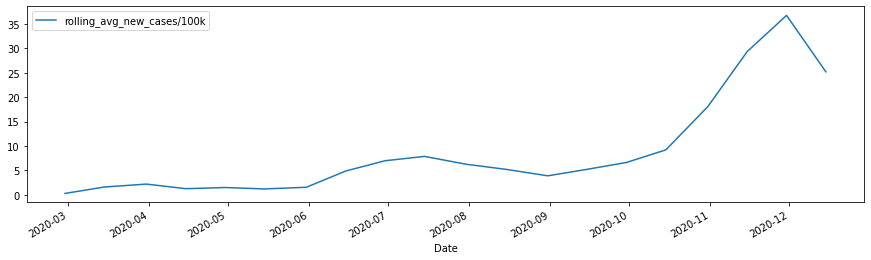

In [ ]:
df_washington_county[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))


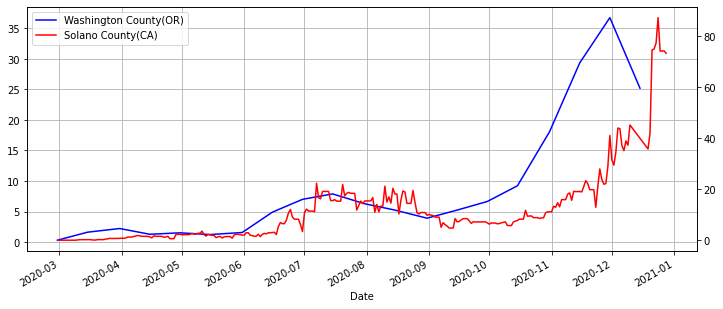

In [ ]:
plt.figure(figsize=(12,5))
plt.xlabel('Number of requests every 10 minutes')

ax1 = df_washington_county["rolling_avg_new_cases/100k"].plot(color='blue', grid=True, label='Washington County(OR)')
ax2 = df_solano_county["rolling_avg_new_cases/100k"].plot(color='red', grid=True, secondary_y=True, label='Solano County(CA)')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

In [ ]:
df_washington_county_minimal = df_washington_county[df_washington_county['growth_label'] == 'minimal']
df_washington_county_nc = df_washington_county[df_washington_county['growth_label'] == 'nochange']
df_washington_county_widespread = df_washington_county[df_washington_county['growth_label'] == 'widespread']

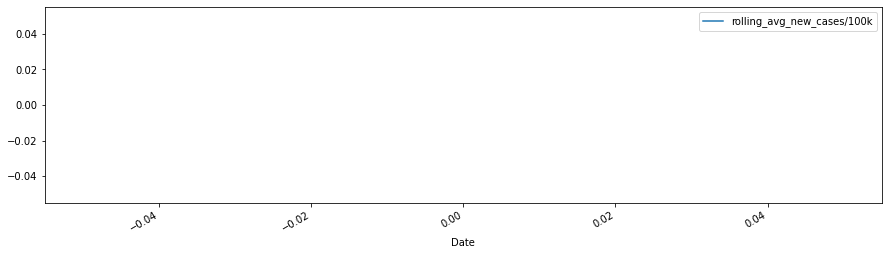

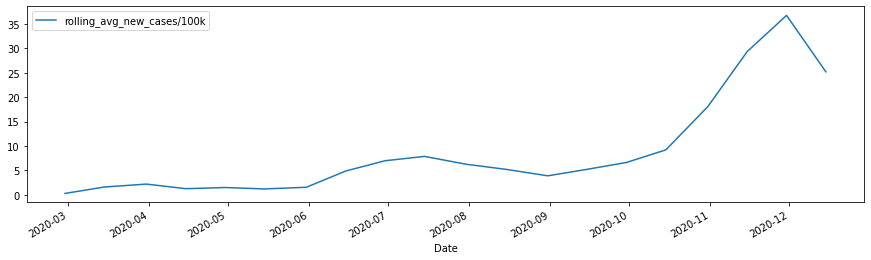

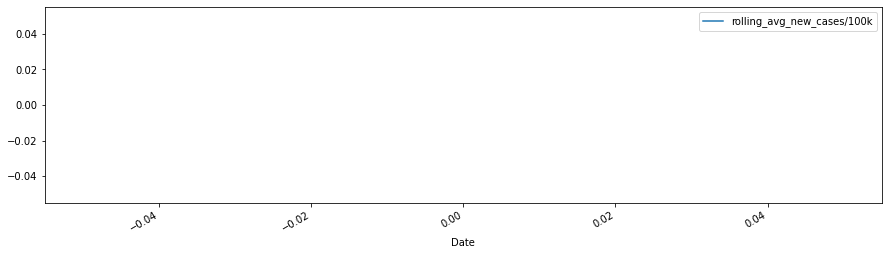

In [ ]:
#df_washington_county.plot(figsize=(15,4))
#df_washington_county.plot(subplots=True, figsize=(15,6))
#df_washington_county_minimal.plot(y=["rolling_avg_new_cases/100k"], figsize=(15,4))
#df_washington_county_nc.plot(y=["rolling_avg_new_cases/100k"], figsize=(15,4))
df_washington_county_minimal[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))
df_washington_county_nc[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))

df_washington_county_widespread[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))


#df.plot(x="R", y=["F10.7", "Dst"], style='.')

In [ ]:
df_Multnomah_County = or_bin_superset_data[or_bin_superset_data['County Name'] == 'Multnomah County']
df_Multnomah_County.head()

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate,growth_label,similiary_score
518,2020-02-29,Oregon,41051.0,0.071429,Multnomah County,0.0,4.281643,84.857143,2.071429,7.285714,25.500000,-2.500000,-1.285714,0.928571,715.275377,Oregon,OR,41051.0,Multnomah County,41.0,23.714286,24.214286,3.540000,32.857143,10.842857,35.478571,0.495000,3.042143,0.071429,811880.0,0.814286,11.61,18.0,64337.0,5.3,11.4,49.54,1180.0,185.0,2.2,0.2,0.024,0.000086,0.002143,29.642857,48.812683,5.992857,0.035714,0.025714,0.214286,4.357143,0.061429,0.000000,1.000000,3.300000,7.250000,0.600000,0.000000,0.008798,0.008798,0.000240,nochange,"(13649, [[0.9102240408728535]])"
519,2020-03-15,Oregon,41051.0,6.187500,Multnomah County,0.0,0.792187,15.250000,-46.625000,-10.687500,12.375000,-46.062500,-41.937500,15.812500,715.275377,Oregon,OR,41051.0,Multnomah County,41.0,52.500000,38.000000,2.869375,29.387500,9.493750,25.856250,0.365625,2.504375,6.187500,811880.0,-16.981250,11.61,18.0,64337.0,5.3,11.4,49.54,1180.0,185.0,2.2,0.2,0.024,0.006900,0.055000,0.000000,49.306294,5.418750,1.125000,1.244375,9.562500,43.687500,0.046250,3.062500,8.468750,6.643750,23.131250,0.600000,3.675000,0.762120,0.481686,0.000613,nochange,"(13649, [[0.910224033966212]])"
520,2020-03-31,Oregon,41051.0,21.333333,Multnomah County,0.0,0.171800,2.933333,-54.066667,-16.333333,12.800000,-56.533333,-53.133333,19.466667,715.275377,Oregon,OR,41051.0,Multnomah County,41.0,59.933333,40.400000,2.764000,28.226667,8.866667,18.960000,0.322667,2.442667,21.333333,811880.0,-19.033333,11.61,18.0,64337.0,5.3,11.4,49.54,1180.0,185.0,2.2,0.2,0.024,0.025180,0.264000,0.066667,50.132514,5.160000,5.416667,5.640667,25.933333,173.266667,0.060667,18.200000,11.873333,13.086667,26.306667,0.226667,12.996000,2.627646,2.262826,0.000465,nochange,"(13664, [[0.9102240509430546]])"
521,2020-04-15,Oregon,41051.0,19.285714,Multnomah County,0.0,0.204000,3.357143,-50.285714,-14.714286,11.571429,-55.000000,-51.071429,18.071429,715.275377,Oregon,OR,41051.0,Multnomah County,41.0,55.928571,38.285714,2.786429,29.714286,9.521429,23.035714,0.295714,2.490714,19.285714,811880.0,-17.457143,11.61,18.0,64337.0,5.3,11.4,49.54,1180.0,185.0,2.2,0.2,0.024,0.023229,0.420714,2.500000,50.062779,4.814286,10.334286,8.497143,25.785714,266.642857,0.092857,33.500000,10.242857,14.614286,28.185714,0.200000,20.927857,2.375439,2.610469,0.000225,nochange,"(13664, [[0.9102240502819475]])"
522,2020-04-30,Oregon,41051.0,16.266667,Multnomah County,0.0,0.355133,6.666667,-45.466667,-8.733333,19.866667,-51.666667,-48.466667,16.733333,715.275377,Oregon,OR,41051.0,Multnomah County,41.0,50.000000,34.733333,2.952000,30.540000,9.906667,24.880000,0.296000,2.653333,16.266667,811880.0,-12.060000,11.61,18.0,64337.0,5.3,11.4,49.54,1180.0,185.0,2.2,0.2,0.024,0.020040,0.422000,3.600

In [ ]:
df_Multnomah_County.index = pd.to_datetime(df_Multnomah_County["Date"])

df_Multnomah_County.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate,growth_label,similiary_score
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-29,2020-02-29,Oregon,41051.0,0.071429,Multnomah County,0.0,4.281643,84.857143,2.071429,7.285714,25.500,-2.5000,-1.285714,0.928571,715.275377,Oregon,OR,41051.0,Multnomah County,41.0,23.714286,24.214286,3.540000,32.857143,10.842857,35.478571,0.495000,3.042143,0.071429,811880.0,0.814286,11.61,18.0,64337.0,5.3,11.4,49.54,1180.0,185.0,2.2,0.2,0.024,0.000086,0.002143,29.642857,48.812683,5.992857,0.035714,0.025714,0.214286,4.357143,0.061429,0.0000,1.00000,3.30000,7.25000,0.6,0.000,0.008798,0.008798,0.000240,nochange,"(13649, [[0.9102240408728535]])"
2020-03-15,2020-03-15,Oregon,41051.0,6.187500,Multnomah County,0.0,0.792187,15.250000,-46.625000,-10.687500,12.375,-46.0625,-41.937500,15.812500,715.275377,Oregon,OR,41051.0,Multnomah County,41.0,52.500000,38.000000,2.869375,29.387500,9.493750,25.856250,0.365625,2.504375,6.187500,811880.0,-16.981250,11.61,18.0,64337.0,5.3,11.4,49.54,1180.0,185.0,2.2,0.2,0.024,0.006900,0.055000,0.000000,49.306294,5.418750,1.125000,1.244375,9.562500,43.687500,0.046250,3.0625,8.46875,6.64375,23.13125,0.6,3.675,0.762120,0.481686,0.000613,nochange,"(13649, [[0.910224033966212]])"


In [ ]:
df_Multnomah_County_minimal = df_Multnomah_County[df_Multnomah_County['growth_label'] == 'minimal']
df_Multnomah_County_nc = df_Multnomah_County[df_Multnomah_County['growth_label'] == 'nochange']
df_Multnomah_County_widespread = df_Multnomah_County[df_Multnomah_County['growth_label'] == 'widespread']

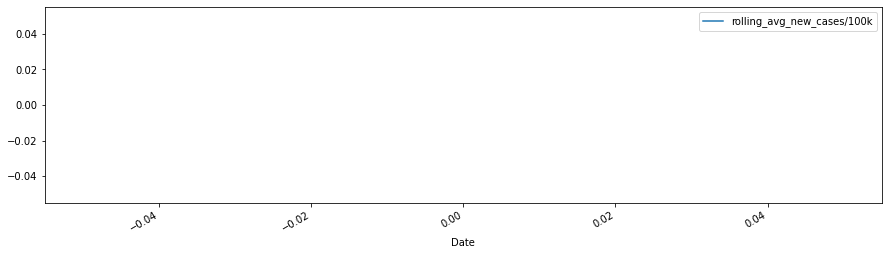

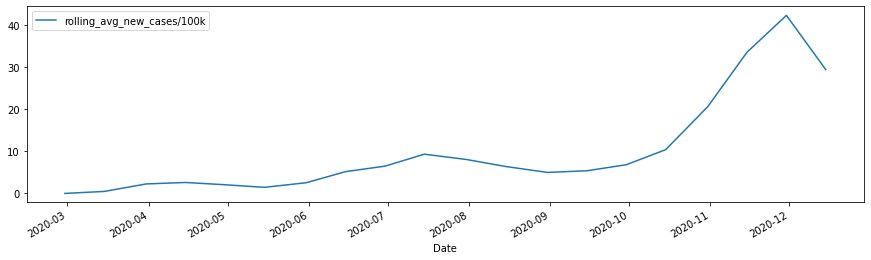

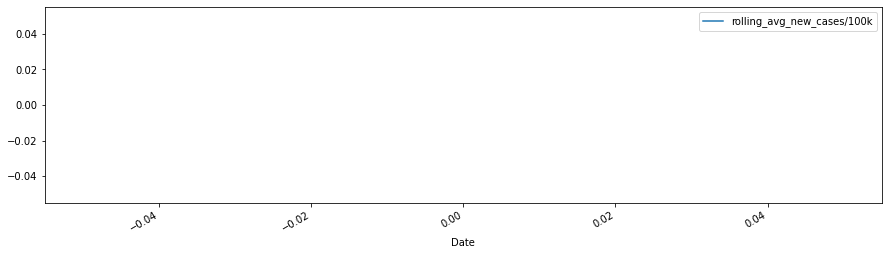

In [ ]:
df_Multnomah_County_minimal[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))
df_Multnomah_County_nc[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))

df_Multnomah_County_widespread[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))

# Conclusion, Details, and Observation-OLD

* I have fixed the and changed the logic of cosine similarity code
* There are two options, I have followed to compute the similarity score for Oregon

> 1. **Option1:** A= Oregon , B= CA ; Outer loop= OR, Inner Loop= CA
>> * I have taken Oregon data and all the labeled CA data
>> * Then I have compared each row of Oregon with all the rows of CA labeled data. I cann't filter here the 'superspread' CA labeled data, because then OR data will be forcefully tagged as 'superspread'.
>> * I have stored the similarity score and the CA dataframe's row number pair in Oregon dataframe. 
>> * So now each row of Oregon dataset has the similarity score with the matching row number of CA dataframe.

> **2. Option2:** A= CA-Superspread B= Oregon ,  ; Outer loop= CA-Superspread, Inner Loop= OR
>> * This is opposite of option-1 and I think this the is the best way.
>> * Here I have filtered the 'superspread' data of CA labeled data
>> * Then I have compared the 'superspread' CA data with each rows of Oregon data to compute the cosine similarity
>> * Final output, for each row in 'superspread' CA data, I am storing the matching/ high similarity row number from Oregon dataset.
>> * Here we have to analize less number of data and only the superspread data
>> * I have analized few rows and found 'Washington County' of Oregon as a superspread county and high similarity with CA superspread data. This is matching with current situation also.